# LDED Audiovisual Fusion 

Author: Chen Lequn.
Created on 11 Oct 2023.

- Material: Maraging Steel 300
- Process: Robotic Laser-directed energy deposition
- Recorded data: position, veolocity, coaxial ccd features, audio feature
- Quality labels generated: keyhole pores, cracks, defect-free

### Notebook 3: Melt pool visual feature prediction using audio feature: baseline regression model
In this notebook:
- develop a ML model to predict representative  melt pool visual features (i.e., ellipse width) using audio features
- We use handcrafted features extracted from previous steps
- This serves as our baseline model

## System setup

In [2]:
# from sklearnex import patch_sklearn, config_context
# import dpctl
# patch_sklearn()

In [58]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal
import os
import math
import sys
from sklearn.utils import shuffle
from scipy.interpolate import griddata

# to make this notebook's output stable across runs
np.random.seed(42)

pd.plotting.register_matplotlib_converters()

import time
import matplotlib as mpl
import matplotlib 
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns
import matplotlib.font_manager as font_manager

import os
from pathlib import Path
import json
import h5py
import joblib
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
# import backoff
from scipy.interpolate import BSpline
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn import (manifold, datasets, decomposition, ensemble,random_projection)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm.notebook import tqdm

In [26]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

In [3]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

# Set the random seed for reproducibility
np.random.seed(42)

PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'meltpool prediction', 'basline-regression')
model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models", 'meltpool prediction', 'ML-basline')
os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

Multimodal_dataset_PATH = "/home/lequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')
                            

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

## Retrieve multisensor dataframe

In [94]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['X', 'Y', 'Z', 'Speed'])
df_multimodal

sample index  Time_Stamps      audio_file_name      image_file_name  \
0                 1         0.00      sample_21_1.wav      sample_21_1.jpg   
1                 2         0.04      sample_21_2.wav      sample_21_2.jpg   
2                 3         0.08      sample_21_3.wav      sample_21_3.jpg   
3                 4         0.12      sample_21_4.wav      sample_21_4.jpg   
4                 5         0.16      sample_21_5.wav      sample_21_5.jpg   
...             ...          ...                  ...                  ...   
61989         13524       540.92  sample_32_13524.wav  sample_32_13524.jpg   
61990         13525       540.96  sample_32_13525.wav  sample_32_13525.jpg   
61991         13526       541.00  sample_32_13526.wav  sample_32_13526.jpg   
61992         13527       541.04  sample_32_13527.wav  sample_32_13527.jpg   
61993         13528       541.08  sample_32_13528.wav  sample_32_13528.jpg   

        class_name class_name_v2  Layer number  Sample number  rms_energy  \
0        Laser-off     Laser-off           1.0             21    0.009018   
1      Defect-free   Defect-free           1.0             21    0.019286   
2      Defect-free   Defect-free           1.0             21    0.019593   
3      Defect-free   Defect-free           1.0             21    0.030937   
4      Defect-free   Defect-free           1.0             21    0.038329   
...            ...           ...           ...            ...         ...   
61989          NaN           NaN           NaN             32    0.048554   
61990          NaN           NaN           NaN             32    0.040282   
61991          NaN           NaN           NaN             32    0.052285   
61992          NaN           NaN           NaN             32    0.023477   
61993          NaN           NaN           NaN             32    0.027721   

       amplitude_envelope_mean  ...    center_y  contour_area  contour_length  \
0                     0.003034  ...    0.000000           0.0        0.000000   
1                     0.012109  ...  239.000000      305442.0     2234.000000   
2                     0.015114  ...  239.000000      305442.0     2234.000000   
3                     0.021501  ...  230.264496      291865.5     2279.781744   
4                     0.029851  ...  229.109962      281970.0     2407.847760   
...                        ...  ...         ...           ...             ...   
61989                 0.036195  ...    0.000000           0.0        0.000000   
61990                 0.032946  ...    0.000000           0.0        0.000000   
61991                 0.042469  ...    0.000000           0.0        0.000000   
61992                 0.016409  ...    0.000000           0.0        0.000000   
61993                 0.023430  ...    0.000000           0.0        0.000000   

           X       Y      Z     Vx      Vy     Vz   Speed  
0      0.000   0.000  0.000  0.000  -0.000  0.000   0.000  
1      0.000  -0.000  0.001 -0.074  -0.074  0.000   0.105  
2     -0.010   0.015 -0.007 -0.051   0.026 -0.051   0.077  
3     -0.007   0.016  0.010  0.173  -0.222  2.520   2.536  
4     -0.111   0.123 -0.057 -1.864   1.662 -2.468   3.511  
...      ...     ...    ...    ...     ...    ...     ...  
61989  3.017  22.125  7.629  1.104 -24.165  0.427  24.194  
61990  3.011  21.169  7.622 -0.804 -24.051 -0.553  24.071  
61991  2.999  20.204  7.613  0.049 -23.766  0.636  23.775  
61992  2.997  19.250  7.622 -0.811 -24.167 -0.634  24.189  
61993  2.989  18.295  7.630  0.098 -23.833  0.738  23.845  

[61341 rows x 134 columns]

In [95]:
df_multimodal_97 = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal_dropped_97.h5'), key='df')
df_multimodal_97

sample index  Time_Stamps      audio_file_name      image_file_name  \
0                 1         0.00      sample_21_1.wav      sample_21_1.jpg   
1                 2         0.04      sample_21_2.wav      sample_21_2.jpg   
2                 3         0.08      sample_21_3.wav      sample_21_3.jpg   
3                 4         0.12      sample_21_4.wav      sample_21_4.jpg   
4                 5         0.16      sample_21_5.wav      sample_21_5.jpg   
...             ...          ...                  ...                  ...   
48461         10982       439.24  sample_26_10982.wav  sample_26_10982.jpg   
48462         10983       439.28  sample_26_10983.wav  sample_26_10983.jpg   
48463         10984       439.32  sample_26_10984.wav  sample_26_10984.jpg   
48464         10985       439.36  sample_26_10985.wav  sample_26_10985.jpg   
48465         10986       439.40  sample_26_10986.wav  sample_26_10986.jpg   

        class_name class_name_v2  Layer number  Sample number  \
0        Laser-off     Laser-off           1.0             21   
1      Defect-free   Defect-free           1.0             21   
2      Defect-free   Defect-free           1.0             21   
3      Defect-free   Defect-free           1.0             21   
4      Defect-free   Defect-free           1.0             21   
...            ...           ...           ...            ...   
48461    Laser-off     Laser-off           NaN             26   
48462    Laser-off     Laser-off           NaN             26   
48463    Laser-off     Laser-off           NaN             26   
48464    Laser-off     Laser-off           NaN             26   
48465    Laser-off     Laser-off           NaN             26   

       amplitude_envelope_std  zero_crossing_rate  ...      nu03    center_y  \
0                    0.003803            0.129819  ...  0.000000    0.000000   
1                    0.006188            0.210317  ...  0.000000  239.000000   
2                    0.005868            0.200680  ...  0.000000  239.000000   
3                    0.010559            0.160431  ...  0.000891  230.264496   
4                    0.013688            0.113379  ...  0.001388  229.109962   
...                       ...                 ...  ...       ...         ...   
48461                0.003904            0.018707  ...  0.000000    0.000000   
48462                0.003369            0.023810  ...  0.000000    0.000000   
48463                0.003854            0.017007  ...  0.000000    0.000000   
48464                0.003729            0.013605  ...  0.000000    0.000000   
48465                0.003268            0.007370  ...  0.000000    0.000000   

       contour_area      X      Y      Z     Vx     Vy     Vz  Speed  
0               0.0  0.000  0.000  0.000  0.000 -0.000  0.000  0.000  
1          305442.0  0.000 -0.000  0.001 -0.074 -0.074  0.000  0.105  
2          305442.0 -0.010  0.015 -0.007 -0.051  0.026 -0.051  0.077  
3          291865.5 -0.007  0.016  0.010  0.173 -0.222  2.520  2.536  
4          281970.0 -0.111  0.123 -0.057 -1.864  1.662 -2.468  3.511  
...             ...    ...    ...    ...    ...    ...    ...    ...  
48461           0.0  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  
48462           0.0  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  
48463           0.0  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  
48464           0.0  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  
48465           0.0  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  

[32946 rows x 109 columns]

### Split data into Features X and Lable Y

In [96]:
# List of audio features to be used
audio_features = [
        'rms_energy', 'amplitude_envelope_mean','amplitude_envelope_std', 'zero_crossing_rate', 'dynamic_complexity',
        'loudness', 'loudness_vickers', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_complexity_mean',
        'spectral_complexity_std', 'spectral_contrast_0_mean', 'spectral_contrast_0_std', 'spectral_contrast_1_mean',
        'spectral_contrast_1_std', 'spectral_contrast_2_mean', 'spectral_contrast_2_std', 'spectral_contrast_3_mean',
        'spectral_contrast_3_std', 'spectral_contrast_4_mean', 'spectral_contrast_4_std', 'spectral_contrast_5_mean',
        'spectral_contrast_5_std', 'spectral_valley_0_mean', 'spectral_valley_0_std', 'spectral_valley_1_mean',
        'spectral_valley_1_std', 'spectral_valley_2_mean', 'spectral_valley_2_std', 'spectral_valley_3_mean',
        'spectral_valley_3_std', 'spectral_valley_4_mean','spectral_valley_4_std', 'spectral_valley_5_mean',
        'spectral_valley_5_std', 'spectral_decrease_mean', 'spectral_decrease_std', 'spectral_energy_mean', 'spectral_energy_std',
        'spectral_energy_band_ratio_mean', 'spectral_energy_band_ratio_std',
        'spectral_flatness_mean', 'spectral_flatness_std', 'spectral_flux_mean', 'spectral_flux_std', 'spectral_rolloff_mean', 'spectral_rolloff_std',
        'spectral_strong_peak_mean', 'spectral_strong_peak_std', 'spectral_variance_mean', 'spectral_variance_std',
        'spectral_skewness_mean', 'spectral_skewness_std','spectral_kurtosis_mean', 'spectral_kurtosis_std',
        'spectral_crest_factor_mean', 'spectral_crest_factor_std','mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean',
        'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std',
        'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean',
        'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std',
        'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std','mfcc_12_mean', 'mfcc_12_std', "Speed", "X", "Y", "Z",
    ]

redundant_audio_features_090 = ['spectral_decrease_mean', 'spectral_decrease_std', 'amplitude_envelope_std', 
                               'amplitude_envelope_mean', 'rms_energy', 'spectral_energy_mean', 'spectral_energy_std', 
                               'spectral_skewness_mean', 'spectral_energy_band_ratio_mean', 'zero_crossing_rate', 
                               'spectral_valley_1_mean', 'mfcc_0_mean', 'spectral_strong_peak_std','dynamic_complexity','loudness']

# Visual features to be predicted
target_visual_features = ['max_contour_area', 'ellipse_width', 'contour_length', 'rectangle_width', 'nu02']

# Filter out the columns based on selected features
# X = df_multimodal[audio_features].drop(columns=redundant_audio_features_090).to_numpy() 
X = df_multimodal[audio_features].to_numpy() 
Y = df_multimodal[target_visual_features].to_numpy() 

# Split the target Y into separate arrays for each visual feature
Y_max_contour = Y[:, 0]
Y_ellipse_width = Y[:, 1]
Y_contour_length = Y[:, 2]
Y_rectangle_width = Y[:, 3]
Y_nu02 = Y[:, 4]

# Show the shape of each target array to confirm the split
X.shape, Y_max_contour.shape, Y_ellipse_width.shape, Y_contour_length.shape, Y_rectangle_width.shape, Y_nu02.shape

((61341, 87), (61341,), (61341,), (61341,), (61341,), (61341,))

In [97]:
print (X.shape)
print (Y.shape)

(61341, 87)
(61341, 5)


## Split the dataset into *train*, *validation*, and *test*
- Ratio: 0.8, 0.1, 0.1

In [98]:
from sklearn.model_selection import train_test_split

# Define the split ratio
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# First, split the dataset into training and temporary sets (to be further divided into validation and test sets)

X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=test_ratio, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=val_ratio/(train_ratio + val_ratio), random_state=42)


Y_max_contour_train = Y_train[:, 0]
Y_ellipse_width_train = Y_train[:, 1]
Y_contour_length_train = Y_train[:, 2]
Y_rectangle_width_train = Y_train[:, 3]
Y_nu02_train = Y_train[:, 4]


Y_max_contour_test = Y_test[:, 0]
Y_ellipse_width_test = Y_test[:, 1]
Y_contour_length_test = Y_test[:, 2]
Y_rectangle_width_test = Y_test[:, 3]
Y_nu02_test = Y_test[:, 4]

Y_max_contour_val = Y_val[:, 0]
Y_ellipse_width_val = Y_val[:, 1]
Y_contour_length_val = Y_val[:, 2]
Y_rectangle_width_val = Y_val[:, 3]
Y_nu02_val = Y_val[:, 4]


# Show the shape of each split to confirm the process
(X_train.shape, X_val.shape, X_test.shape)

((49072, 87), (6134, 87), (6135, 87))

In [99]:
(Y_max_contour_train.shape, Y_max_contour_val.shape, Y_max_contour_test.shape)

((49072,), (6134,), (6135,))

In [100]:
(Y_contour_length_train.shape, Y_contour_length_val.shape, Y_contour_length_test.shape)

((49072,), (6134,), (6135,))

In [101]:
(Y_rectangle_width_train.shape, Y_rectangle_width_val.shape, Y_rectangle_width_test.shape)

((49072,), (6134,), (6135,))

In [102]:
(Y_ellipse_width_train.shape, Y_ellipse_width_val.shape, Y_ellipse_width_test.shape)

((49072,), (6134,), (6135,))

In [103]:
(Y_nu02_train.shape, Y_nu02_val.shape, Y_nu02_test.shape)

((49072,), (6134,), (6135,))

## Data standarization

In [104]:
scaler_all = preprocessing.StandardScaler()
X_train_transformed = scaler_all.fit_transform(X_train)
X_val_transformed = scaler_all.transform(X_val)
X_test_transformed = scaler_all.transform(X_test)

## 1. ellipse width (melt pool width)
## 2. nu02 (second moment of area)
## 3. rectangle width

### Hyperparameter tuning (Grid Search)

Select a `20%` random subset of the training data for hyperparameter tuning

In [107]:
# Select a 20% random subset of the training data for hyperparameter tuning
subset_size = int(0.3 * X_train_transformed.shape[0])
random_indices = np.random.choice(X_train_transformed.shape[0], subset_size, replace=False)

# Subset for X and Y_max_contour
X_train_subset = X_train_transformed[random_indices, :]

Y_max_contour_train_subset = Y_max_contour_train[random_indices]
Y_ellipse_width_train_subset = Y_ellipse_width_train[random_indices]
Y_rectangle_width_train_subset = Y_rectangle_width_train[random_indices]
Y_nu02_train_subset = Y_nu02_train[random_indices]

X_train_subset.shape, Y_max_contour_train_subset.shape, Y_nu02_train_subset.shape

((14721, 87), (14721,), (14721,))

In [ ]:
# Define the parameter grids
param_grids = {
    'RandomForestRegressor': {
        'n_estimators': [50, 100, 400],
        # 'max_depth': [30, 100],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [2, 10]
    },
    'DecisionTreeRegressor': {
        'max_depth': [10, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Ridge': {
        'alpha': [0.01,  0.1, 1, 10, 100],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'SVR': {
        'C': [0.1, 1],
        'epsilon': [0.01, 0.1],
        'kernel': ['linear', 'rbf']
    },
    'KNeighborsRegressor': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'MLPRegressor': {
        'hidden_layer_sizes': [(16,64,256), (32,64,256), (100, 100, 100)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'learning_rate_init': [0.001, 0.01],
        'max_iter': [10000],
    },
    'GaussianProcessRegressor': {
        # 'normalize_y': [True, False],
        'alpha': [1e-10, 1e-9]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'XGBRegressor': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'LGBMRegressor': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    
    'Lasso': {
        'alpha': [0.001, 0.1,  10],
        'max_iter': [1000, 10000],
        'tol': [0.0001, 0.001, 0.01],
        'selection': ['cyclic', 'random']  # The algorithm for updating coefficients
    },

    'AdaBoostRegressor': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 1],
        'loss': ['linear', 'square', 'exponential']
    },

    'ElasticNet': {
        'alpha': [0.01, 1, 10],
        'l1_ratio': [0.2, 0.8],
        'max_iter': [1000, 5000]
    },
}


# Models to train
models_to_train = {
    # 'Ridge': Ridge(),
    # 'KNeighborsRegressor': KNeighborsRegressor(),
    # 'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    # 'MLPRegressor': MLPRegressor(random_state=42),
    # 'RandomForestRegressor': RandomForestRegressor(random_state=42),
    # 'SVR': SVR(),
    # 'GaussianProcessRegressor': GaussianProcessRegressor(random_state=42),
    # 'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    # 'XGBRegressor': XGBRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(random_state=42),
    'Lasso': Lasso(),
    'AdaBoostRegressor': AdaBoostRegressor(random_state=42),
    'ElasticNet': ElasticNet(),
}

# Initialize KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# For storing the best parameters and scores
best_params = {}
best_scores = {}

for model_name, model in models_to_train.items():
    print(f"\nPerforming GridSearchCV for {model_name}...")
    
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grids[model_name],
                               cv=kf, n_jobs=14, verbose=1) # total cores: 16
    grid_search.fit(X_train_subset, Y_ellipse_width_train_subset)
    
    best_params[model_name] = grid_search.best_params_
    best_scores[model_name] = grid_search.best_score_
    print (f"best score for {model_name}: {grid_search.best_score_}")
    print (f"best hyperparameters for {model_name}: {grid_search.best_params_}")


Performing GridSearchCV for Ridge...
Fitting 5 folds for each of 35 candidates, totalling 175 fits
best score for Ridge: 0.3076524159830485
best hyperparameters for Ridge: {'alpha': 0.01, 'solver': 'auto'}

Performing GridSearchCV for KNeighborsRegressor...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
best score for KNeighborsRegressor: 0.4611367053089621
best hyperparameters for KNeighborsRegressor: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

Performing GridSearchCV for DecisionTreeRegressor...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
best score for DecisionTreeRegressor: 0.49111774040072875
best hyperparameters for DecisionTreeRegressor: {'max_depth': 10, 'min_samples_split': 10}

Performing GridSearchCV for MLPRegressor...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
best score for MLPRegressor: 0.389900640157811
best hyperparameters for MLPRegressor: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...........alpha=0.01, solver=auto;, score=0.336 total time=   0.0s
[CV 5/5] END .......alpha=0.01, solver=cholesky;, score=0.309 total time=   0.0s
[CV 1/5] END ...........alpha=0.01, solver=lsqr;, score=0.304 total time=   0.5s
[CV 5/5] END ......alpha=0.01, solver=sparse_cg;, score=0.309 total time=   0.4s
[CV 2/5] END .............alpha=0.1, solver=svd;, score=0.336 total time=   0.2s
[CV 2/5] END ........alpha=0.1, solver=cholesky;, score=0.336 total time=   0.0s
[CV 5/5] END ........alpha=0.1, solver=cholesky;, score=0.309 total time=   0.0s
[CV 3/5] END ............alpha=0.1, solver=lsqr;, score=0.221 total time=   0.2s
[CV 3/5] END .......alpha=0.1, solver=sparse_cg;, score=0.267 total time=   0.3s
[CV 4/5] END .............alpha=0.1, solver=sag;, score=0.319 total time=  17.3s
[CV 5/5] END ..............alpha=1, solver=lsqr;, score=0.309 total time=   0.2s
[CV 3/5] END .........alpha=1, solver=sparse_cg;, score=0.259 total time=   0.2s
[CV 2/5] END ...............

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......alpha=0.01, solver=cholesky;, score=0.305 total time=   0.1s
[CV 1/5] END ......alpha=0.01, solver=sparse_cg;, score=0.305 total time=   0.5s
[CV 1/5] END ............alpha=0.1, solver=auto;, score=0.305 total time=   0.0s
[CV 3/5] END ............alpha=0.1, solver=auto;, score=0.270 total time=   0.0s
[CV 1/5] END .............alpha=0.1, solver=svd;, score=0.305 total time=   0.1s
[CV 5/5] END .............alpha=0.1, solver=svd;, score=0.309 total time=   0.2s
[CV 4/5] END ............alpha=0.1, solver=lsqr;, score=0.318 total time=   0.2s
[CV 1/5] END .......alpha=0.1, solver=sparse_cg;, score=0.305 total time=   0.2s
[CV 4/5] END .......alpha=0.1, solver=sparse_cg;, score=0.318 total time=   0.1s
[CV 1/5] END .............alpha=0.1, solver=sag;, score=0.303 total time=  16.8s
[CV 5/5] END ............alpha=0.1, solver=saga;, score=0.306 total time=  20.5s
[CV 3/5] END .............alpha=10, solver=saga;, score=0.224 total time=  13.2s
[CV 5/5] END .............al

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...........alpha=0.01, solver=auto;, score=0.309 total time=   0.1s
[CV 3/5] END ...........alpha=0.01, solver=lsqr;, score=0.221 total time=   0.6s
[CV 3/5] END ...........alpha=0.01, solver=saga;, score=0.247 total time=  19.6s
[CV 5/5] END ...............alpha=1, solver=sag;, score=0.308 total time=  17.8s
[CV 3/5] END ..............alpha=10, solver=sag;, score=0.227 total time=   7.4s
[CV 3/5] END .............alpha=100, solver=sag;, score=0.229 total time=   2.0s
[CV 4/5] END .............alpha=100, solver=sag;, score=0.316 total time=  11.6s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.369 total time=   1.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.439 total time=   1.1s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.452 total time=   1.1s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.447 total time=   4.4s
[CV 2/5] END metric=manhattan, n_neighbors=7, weig

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ............alpha=0.01, solver=svd;, score=0.318 total time=   0.5s
[CV 4/5] END ............alpha=0.01, solver=sag;, score=0.319 total time=  17.2s
[CV 1/5] END ............alpha=0.1, solver=saga;, score=0.299 total time=  20.6s
[CV 5/5] END ..............alpha=10, solver=sag;, score=0.308 total time=  17.2s
[CV 3/5] END ............alpha=100, solver=saga;, score=0.229 total time=   3.1s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.390 total time=   1.4s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.457 total time=   1.3s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.450 total time=   4.4s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.464 total time=   4.0s
[CV 4/5] END .max_depth=10, min_samples_split=2;, score=0.469 total time=   1.1s
[CV 4/5] END .max_depth=30, min_samples_split=2;, score=0.257 total time=   2.1s
[CV 2/5] END activation=relu, hidden_layer_sizes=(1

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...........alpha=0.01, solver=auto;, score=0.305 total time=   0.0s
[CV 2/5] END ...........alpha=0.01, solver=lsqr;, score=0.336 total time=   0.6s
[CV 5/5] END ............alpha=0.01, solver=sag;, score=0.308 total time=  17.8s
[CV 4/5] END ............alpha=0.1, solver=saga;, score=0.318 total time=  20.8s
[CV 4/5] END .............alpha=10, solver=saga;, score=0.318 total time=  19.3s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.320 total time=   1.3s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.387 total time=   1.2s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.388 total time=   4.4s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.449 total time=   4.1s
[CV 3/5] END .max_depth=10, min_samples_split=2;, score=0.516 total time=   1.0s
[CV 2/5] END .max_depth=30, min_samples_split=2;, score=0.232 total time=   1.9s
[CV 5/5] END max_depth=30, min_samples_split=10;, s

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: Convergen

[CV 2/5] END .......alpha=0.01, solver=cholesky;, score=0.336 total time=   0.1s
[CV 2/5] END ......alpha=0.01, solver=sparse_cg;, score=0.336 total time=   0.4s
[CV 5/5] END ...........alpha=0.01, solver=saga;, score=0.306 total time=  19.9s
[CV 3/5] END ..............alpha=1, solver=saga;, score=0.244 total time=  20.6s
[CV 5/5] END .............alpha=10, solver=saga;, score=0.306 total time=  18.4s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.337 total time=   1.3s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.445 total time=   1.3s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.398 total time=   4.5s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.414 total time=   4.1s
[CV 2/5] END .max_depth=10, min_samples_split=5;, score=0.490 total time=   1.1s
[CV 2/5] END max_depth=30, min_samples_split=10;, score=0.349 total time=   2.2s
[CV 3/5] END activation=relu, hidden_layer_sizes=(1

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...........alpha=0.01, solver=auto;, score=0.271 total time=   0.0s
[CV 4/5] END ...........alpha=0.01, solver=lsqr;, score=0.318 total time=   0.6s
[CV 2/5] END ...........alpha=0.01, solver=saga;, score=0.331 total time=  19.9s
[CV 2/5] END ..............alpha=1, solver=saga;, score=0.331 total time=  20.8s
[CV 1/5] END ............alpha=100, solver=auto;, score=0.293 total time=   0.0s
[CV 2/5] END ............alpha=100, solver=auto;, score=0.325 total time=   0.0s
[CV 3/5] END ............alpha=100, solver=auto;, score=0.229 total time=   0.0s
[CV 4/5] END ............alpha=100, solver=auto;, score=0.316 total time=   0.0s
[CV 5/5] END ............alpha=100, solver=auto;, score=0.303 total time=   0.0s
[CV 1/5] END .............alpha=100, solver=svd;, score=0.293 total time=   0.1s
[CV 3/5] END .............alpha=100, solver=svd;, score=0.229 total time=   0.1s
[CV 5/5] END .............alpha=100, solver=svd;, score=0.303 total time=   0.1s
[CV 2/5] END ........alpha=1

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ............alpha=0.01, solver=svd;, score=0.336 total time=   0.6s
[CV 1/5] END ...........alpha=0.01, solver=saga;, score=0.299 total time=  19.6s
[CV 4/5] END ...............alpha=1, solver=sag;, score=0.319 total time=  18.0s
[CV 4/5] END ..............alpha=10, solver=sag;, score=0.319 total time=  17.4s
[CV 5/5] END ............alpha=100, solver=saga;, score=0.302 total time=  12.5s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.437 total time=   1.3s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.450 total time=   1.3s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.470 total time=   4.6s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.468 total time=   4.2s
[CV 5/5] END .max_depth=10, min_samples_split=5;, score=0.479 total time=   1.0s
[CV 5/5] END max_depth=10, min_samples_split=10;, score=0.485 total time=   1.1s
[CV 4/5] END max_depth=30, min_samples_split=10;, s

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ............alpha=0.01, solver=svd;, score=0.305 total time=   0.3s
[CV 4/5] END ......alpha=0.01, solver=sparse_cg;, score=0.318 total time=   0.4s
[CV 4/5] END ............alpha=0.1, solver=auto;, score=0.318 total time=   0.0s
[CV 3/5] END .............alpha=0.1, solver=svd;, score=0.270 total time=   0.2s
[CV 3/5] END ........alpha=0.1, solver=cholesky;, score=0.270 total time=   0.0s
[CV 2/5] END ............alpha=0.1, solver=lsqr;, score=0.336 total time=   0.2s
[CV 5/5] END ............alpha=0.1, solver=lsqr;, score=0.309 total time=   0.2s
[CV 5/5] END .......alpha=0.1, solver=sparse_cg;, score=0.309 total time=   0.1s
[CV 3/5] END .............alpha=0.1, solver=sag;, score=0.264 total time=  16.8s
[CV 2/5] END ..............alpha=1, solver=auto;, score=0.336 total time=   0.0s
[CV 4/5] END ..............alpha=1, solver=auto;, score=0.318 total time=   0.0s
[CV 1/5] END ...............alpha=1, solver=svd;, score=0.305 total time=   0.1s
[CV 3/5] END ...............

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ............alpha=0.01, solver=svd;, score=0.309 total time=   0.4s
[CV 3/5] END ............alpha=0.01, solver=sag;, score=0.265 total time=  17.3s
[CV 2/5] END ............alpha=0.1, solver=saga;, score=0.331 total time=  20.6s
[CV 1/5] END .............alpha=10, solver=saga;, score=0.298 total time=  19.4s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.335 total time=   1.3s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.455 total time=   1.2s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.397 total time=   4.3s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.448 total time=   4.4s
[CV 5/5] END .max_depth=10, min_samples_split=2;, score=0.440 total time=   1.1s
[CV 1/5] END .max_depth=30, min_samples_split=5;, score=0.286 total time=   2.2s
[CV 1/5] END activation=relu, hidden_layer_sizes=(16, 64, 256), learning_rate_init=0.01, max_iter=10000, solver=adam;, score=0.354 to

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......alpha=0.01, solver=cholesky;, score=0.271 total time=   0.0s
[CV 3/5] END ......alpha=0.01, solver=sparse_cg;, score=0.268 total time=   0.4s
[CV 2/5] END ............alpha=0.1, solver=auto;, score=0.336 total time=   0.0s
[CV 5/5] END ............alpha=0.1, solver=auto;, score=0.309 total time=   0.0s
[CV 4/5] END .............alpha=0.1, solver=svd;, score=0.318 total time=   0.2s
[CV 1/5] END ........alpha=0.1, solver=cholesky;, score=0.305 total time=   0.0s
[CV 4/5] END ........alpha=0.1, solver=cholesky;, score=0.318 total time=   0.0s
[CV 1/5] END ............alpha=0.1, solver=lsqr;, score=0.304 total time=   0.2s
[CV 2/5] END .......alpha=0.1, solver=sparse_cg;, score=0.336 total time=   0.3s
[CV 2/5] END .............alpha=0.1, solver=sag;, score=0.334 total time=  16.8s
[CV 1/5] END ..............alpha=1, solver=auto;, score=0.305 total time=   0.0s
[CV 3/5] END ..............alpha=1, solver=auto;, score=0.263 total time=   0.0s
[CV 5/5] END ..............a

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...........alpha=0.01, solver=auto;, score=0.318 total time=   0.1s
[CV 5/5] END ...........alpha=0.01, solver=lsqr;, score=0.309 total time=   0.6s
[CV 4/5] END ...........alpha=0.01, solver=saga;, score=0.318 total time=  19.7s
[CV 1/5] END ..............alpha=1, solver=saga;, score=0.299 total time=  21.2s
[CV 2/5] END .............alpha=100, solver=svd;, score=0.325 total time=   0.1s
[CV 4/5] END .............alpha=100, solver=svd;, score=0.316 total time=   0.1s
[CV 1/5] END ........alpha=100, solver=cholesky;, score=0.293 total time=   0.0s
[CV 3/5] END ........alpha=100, solver=cholesky;, score=0.229 total time=   0.0s
[CV 5/5] END ........alpha=100, solver=cholesky;, score=0.303 total time=   0.0s
[CV 2/5] END ............alpha=100, solver=lsqr;, score=0.326 total time=   0.1s
[CV 4/5] END ............alpha=100, solver=lsqr;, score=0.316 total time=   0.1s
[CV 5/5] END ............alpha=100, solver=lsqr;, score=0.303 total time=   0.0s
[CV 2/5] END .......alpha=10

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


best score for RandomForestRegressor: 0.6530426191444766
best hyperparameters for RandomForestRegressor: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}

Performing GridSearchCV for SVR...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
best score for SVR: 0.22629739267524612
best hyperparameters for SVR: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}

Performing GridSearchCV for GaussianProcessRegressor...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 3/5] END C=0.1, epsilon=0.01, kernel=linear;, score=0.159 total time=  49.6s
[CV 4/5] END ....C=0.1, epsilon=0.1, kernel=rbf;, score=0.072 total time=  50.8s
[CV 2/5] END ......C=1, epsilon=0.1, kernel=rbf;, score=0.239 total time=  40.4s
[CV 2/5] END ...C=0.1, epsilon=0.01, kernel=rbf;, score=0.074 total time=  53.2s
[CV 4/5] END ..C=1, epsilon=0.01, kernel=linear;, score=0.217 total time=  48.1s
[CV 3/5] END ......C=1, epsilon=0.1, kernel=rbf;, score=0.203 total time=  39.7s
[CV 1/5] END .

In [34]:
# Output the best parameters and scores
print("\n Best Parameters:", best_params)
print("\n Best Scores:", best_scores)


 Best Parameters: {'Lasso': {'alpha': 0.01, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}, 'AdaBoostRegressor': {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 200}, 'ElasticNet': {'alpha': 0.01, 'l1_ratio': 0.8, 'max_iter': 1000}}

 Best Scores: {'Lasso': 0.30683571252601743, 'AdaBoostRegressor': 0.32560699751367306, 'ElasticNet': 0.3056270814524149}


### Optimal hyperparameters (without adding spatial location) 

best score for Ridge: 0.31334783287852985
best hyperparameters for Ridge: {'alpha': 0.1, 'solver': 'auto'}


best score for KNeighborsRegressor: 0.4114457365926493
best hyperparameters for KNeighborsRegressor: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


best score for RandomForestRegressor: 0.4607933980332751
best hyperparameters for RandomForestRegressor: {'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 400}


best score for DecisionTreeRegressor: 0.2468839245625439
best hyperparameters for DecisionTreeRegressor: {'max_depth': 10, 'min_samples_split': 10}


best score for MLPRegressor: 0.3309951434829902
best hyperparameters for MLPRegressor: {'activation': 'relu', 'hidden_layer_sizes': (16, 64, 256), 'learning_rate_init': 0.001, 'max_iter': 10000, 'solver': 'adam'}


best score for SVR: 0.22547986941568743
best hyperparameters for SVR: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}


best score for GaussianProcessRegressor: -0.9106034549157392
best hyperparameters for GaussianProcessRegressor: {'alpha': 1e-10}


best score for GradientBoostingRegressor: 0.43795407644639966
best hyperparameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


best score for XGBRegressor: 0.44622348350698465
best hyperparameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


best score for LGBMRegressor: 0.4577296699212877
best hyperparameters for LGBMRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}


best score for Lasso: 0.30683571252601743
best hyperparameters for Lasso: {'alpha': 0.01, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}

best score for AdaBoostRegressor: 0.32560699751367306
best hyperparameters for AdaBoostRegressor: {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 200}

best score for ElasticNet: 0.3056270814524149
best hyperparameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.8, 'max_iter': 1000}

### Model training

In [52]:
# Dictionary of models and their optimal hyperparameters
models = {
    'Ridge': (Ridge, {'alpha': 0.1, 'solver': 'auto'}),
    'KNeighborsRegressor': (KNeighborsRegressor, {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}),
    'RandomForestRegressor': (RandomForestRegressor, {'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 400}),
    'DecisionTreeRegressor': (DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 10}),
    'MLPRegressor': (MLPRegressor, {'activation': 'relu', 'hidden_layer_sizes': (16, 64, 256), 'learning_rate_init': 0.001, 'max_iter': 10000, 'solver': 'adam'}),
    'SVR': (SVR, {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}),
    # Uncomment and add GaussianProcessRegressor if necessary
    # 'GaussianProcessRegressor': (GaussianProcessRegressor, {'alpha': 1e-10}),
    'GradientBoostingRegressor': (GradientBoostingRegressor, {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}),
    'XGBRegressor': (XGBRegressor, {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}),
    'LGBMRegressor': (LGBMRegressor, {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}),
    'Lasso': (Lasso, {'alpha': 0.01, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}),
    'AdaBoostRegressor': (AdaBoostRegressor, {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 200}),
    'ElasticNet': (ElasticNet, {'alpha': 0.01, 'l1_ratio': 0.8, 'max_iter': 1000})
}

# Initialize an empty dictionary to store trained models
trained_models = {}


# Training and evaluating each model
for model_name, (ModelClass, params) in models.items():
    model = ModelClass(**params)
    model.fit(X_train_transformed, Y_ellipse_width_train)
    val_score = model.score(X_val_transformed, Y_ellipse_width_val)
    print(f"Validation score for {model_name}: {val_score:.2f}")
    # Save the trained model in the trained_models dictionary
    trained_models[model_name] = model

Validation score for Ridge: 0.31
Validation score for KNeighborsRegressor: 0.43
Validation score for RandomForestRegressor: 0.49
Validation score for DecisionTreeRegressor: 0.30
Validation score for MLPRegressor: 0.49
Validation score for SVR: 0.26
Validation score for GradientBoostingRegressor: 0.45
Validation score for XGBRegressor: 0.46
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20383
[LightGBM] [Info] Number of data points in the train set: 49594, number of used features: 81
[LightGBM] [Info] Start training from score 367.567199
[LightGBM] [Warning] No further splits with positive 

/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.207e+09, tolerance: 7.428e+05
  model = cd_fast.enet_coordinate_descent(


Validation score for Lasso: 0.31
Validation score for AdaBoostRegressor: 0.31
Validation score for ElasticNet: 0.31


/home/lequn/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.320e+09, tolerance: 7.428e+05
  model = cd_fast.enet_coordinate_descent(


### Save the model into pickle files

In [55]:
for model_name, model in trained_models.items():
    filename = f"{model_name}_model.pkl"
    joblib.dump(model, os.path.join(model_path, filename))

### Model performance evaluation

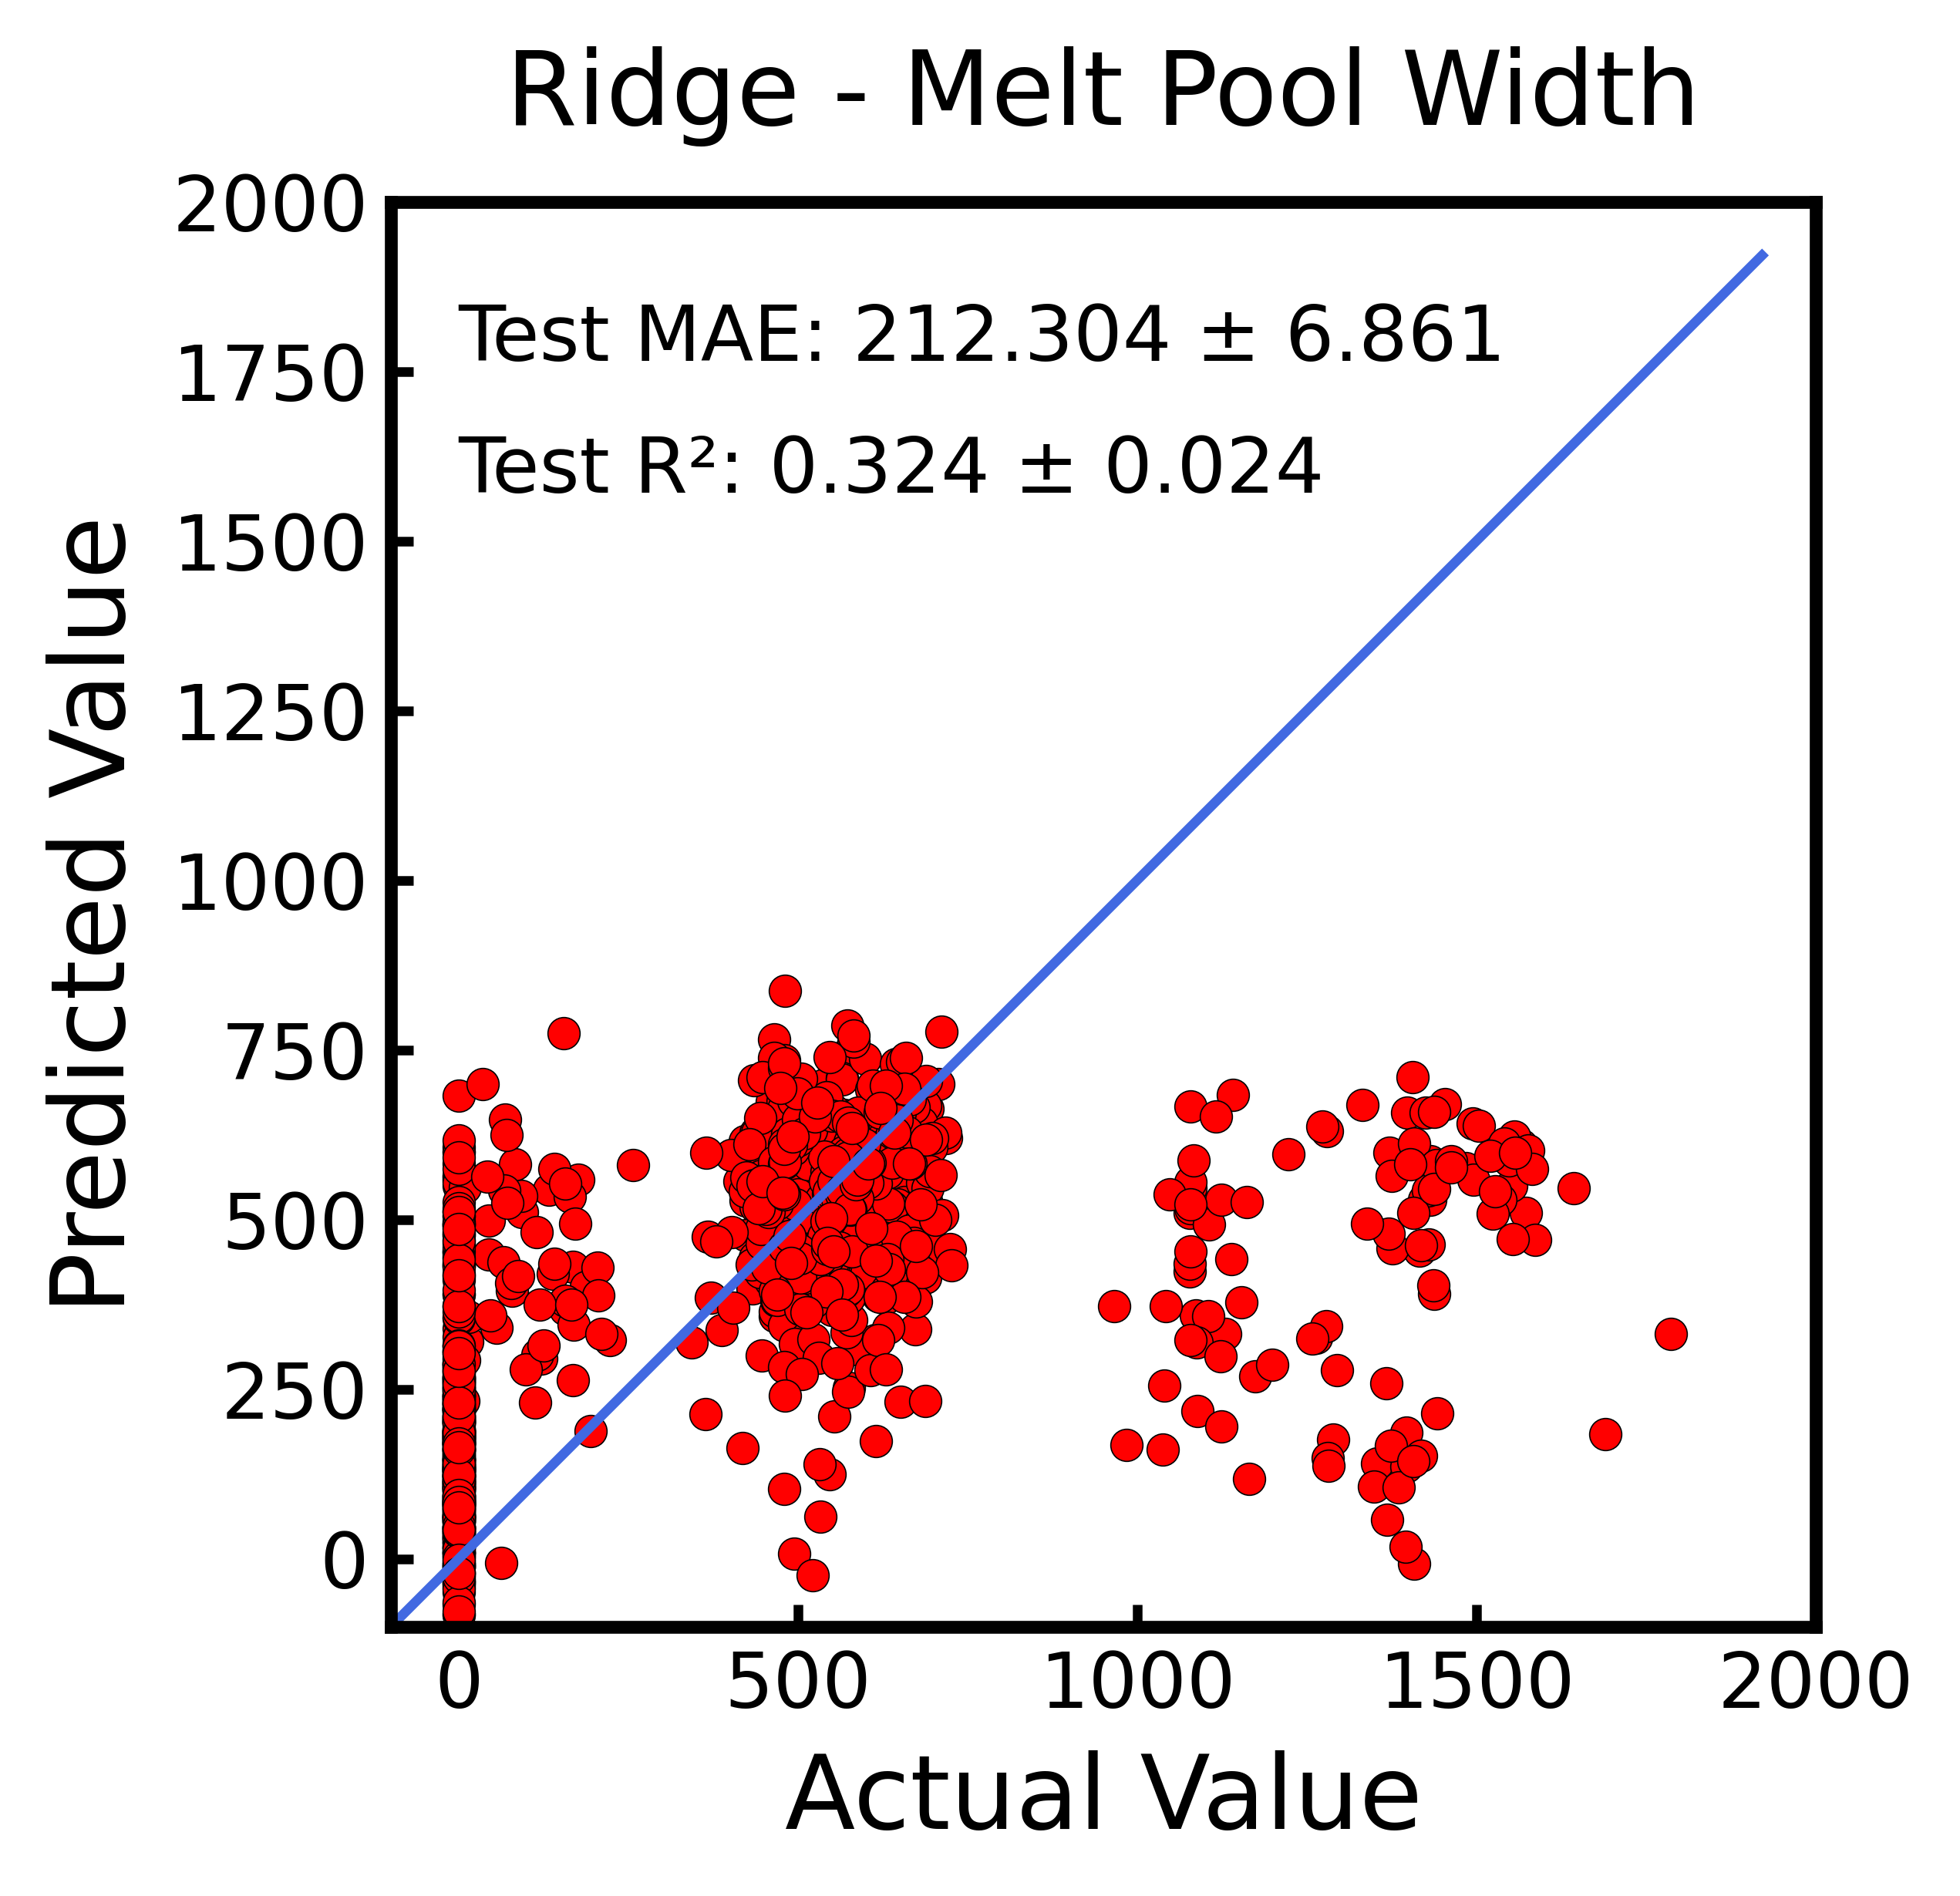

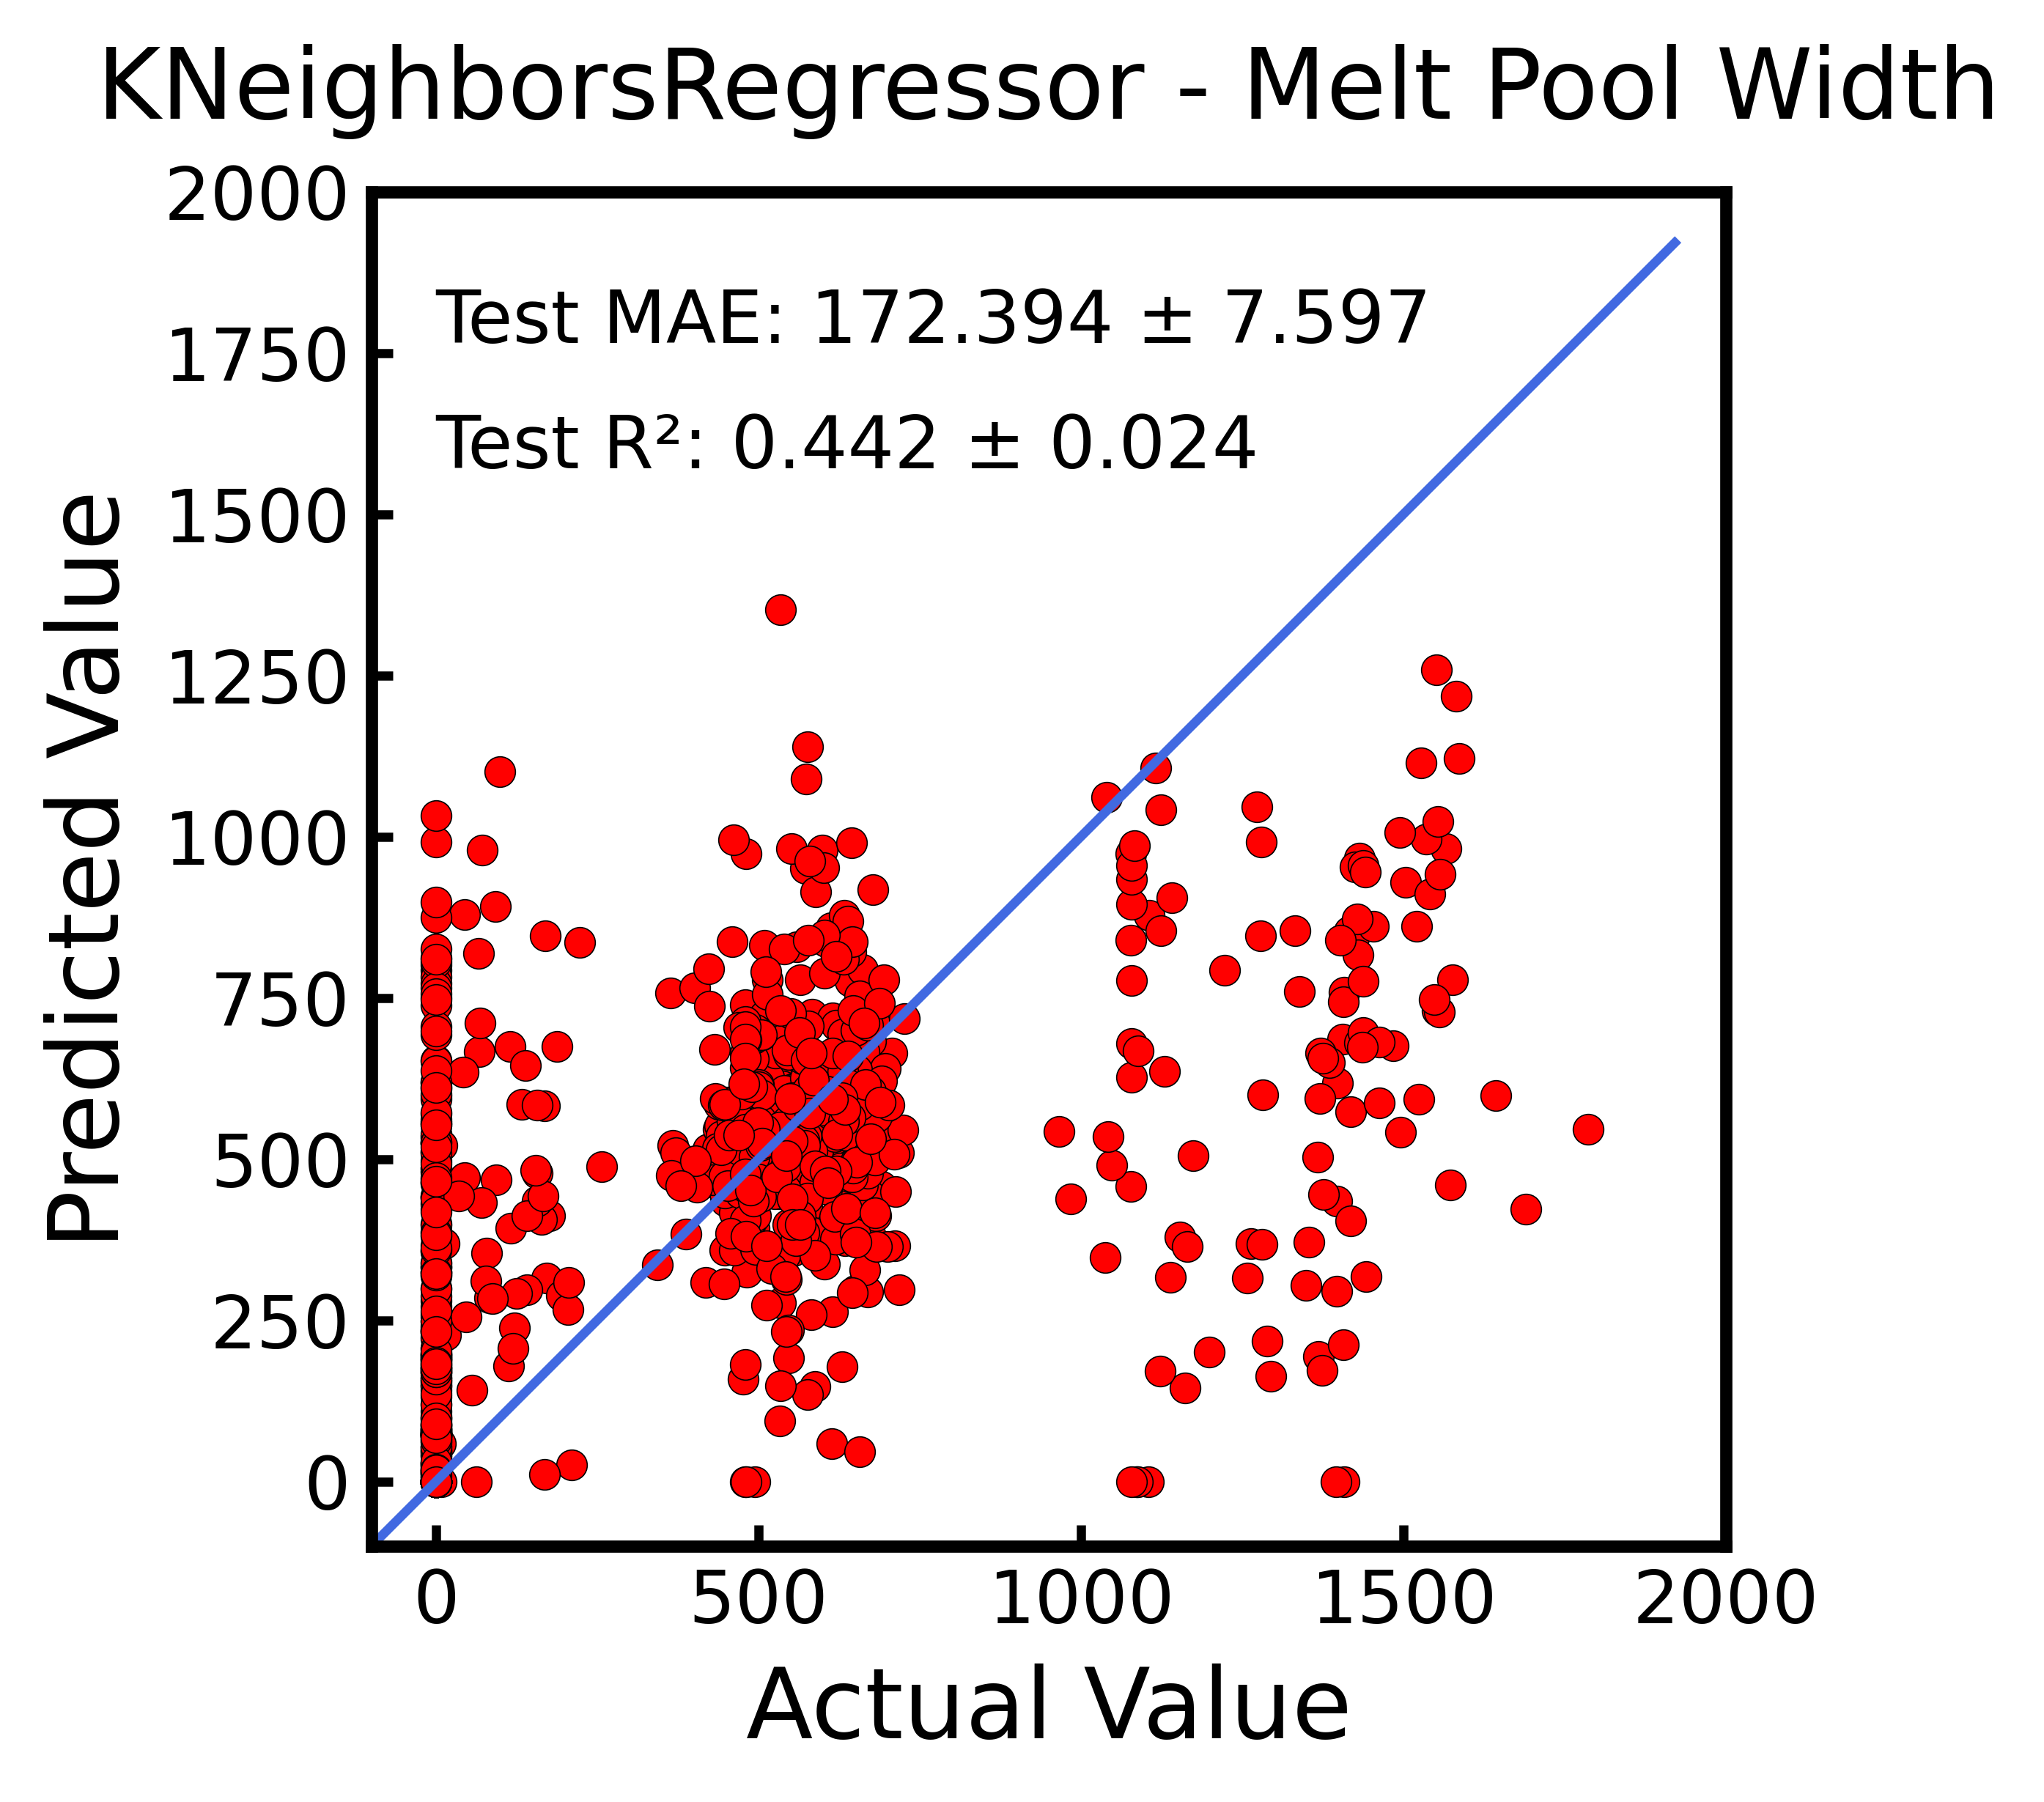

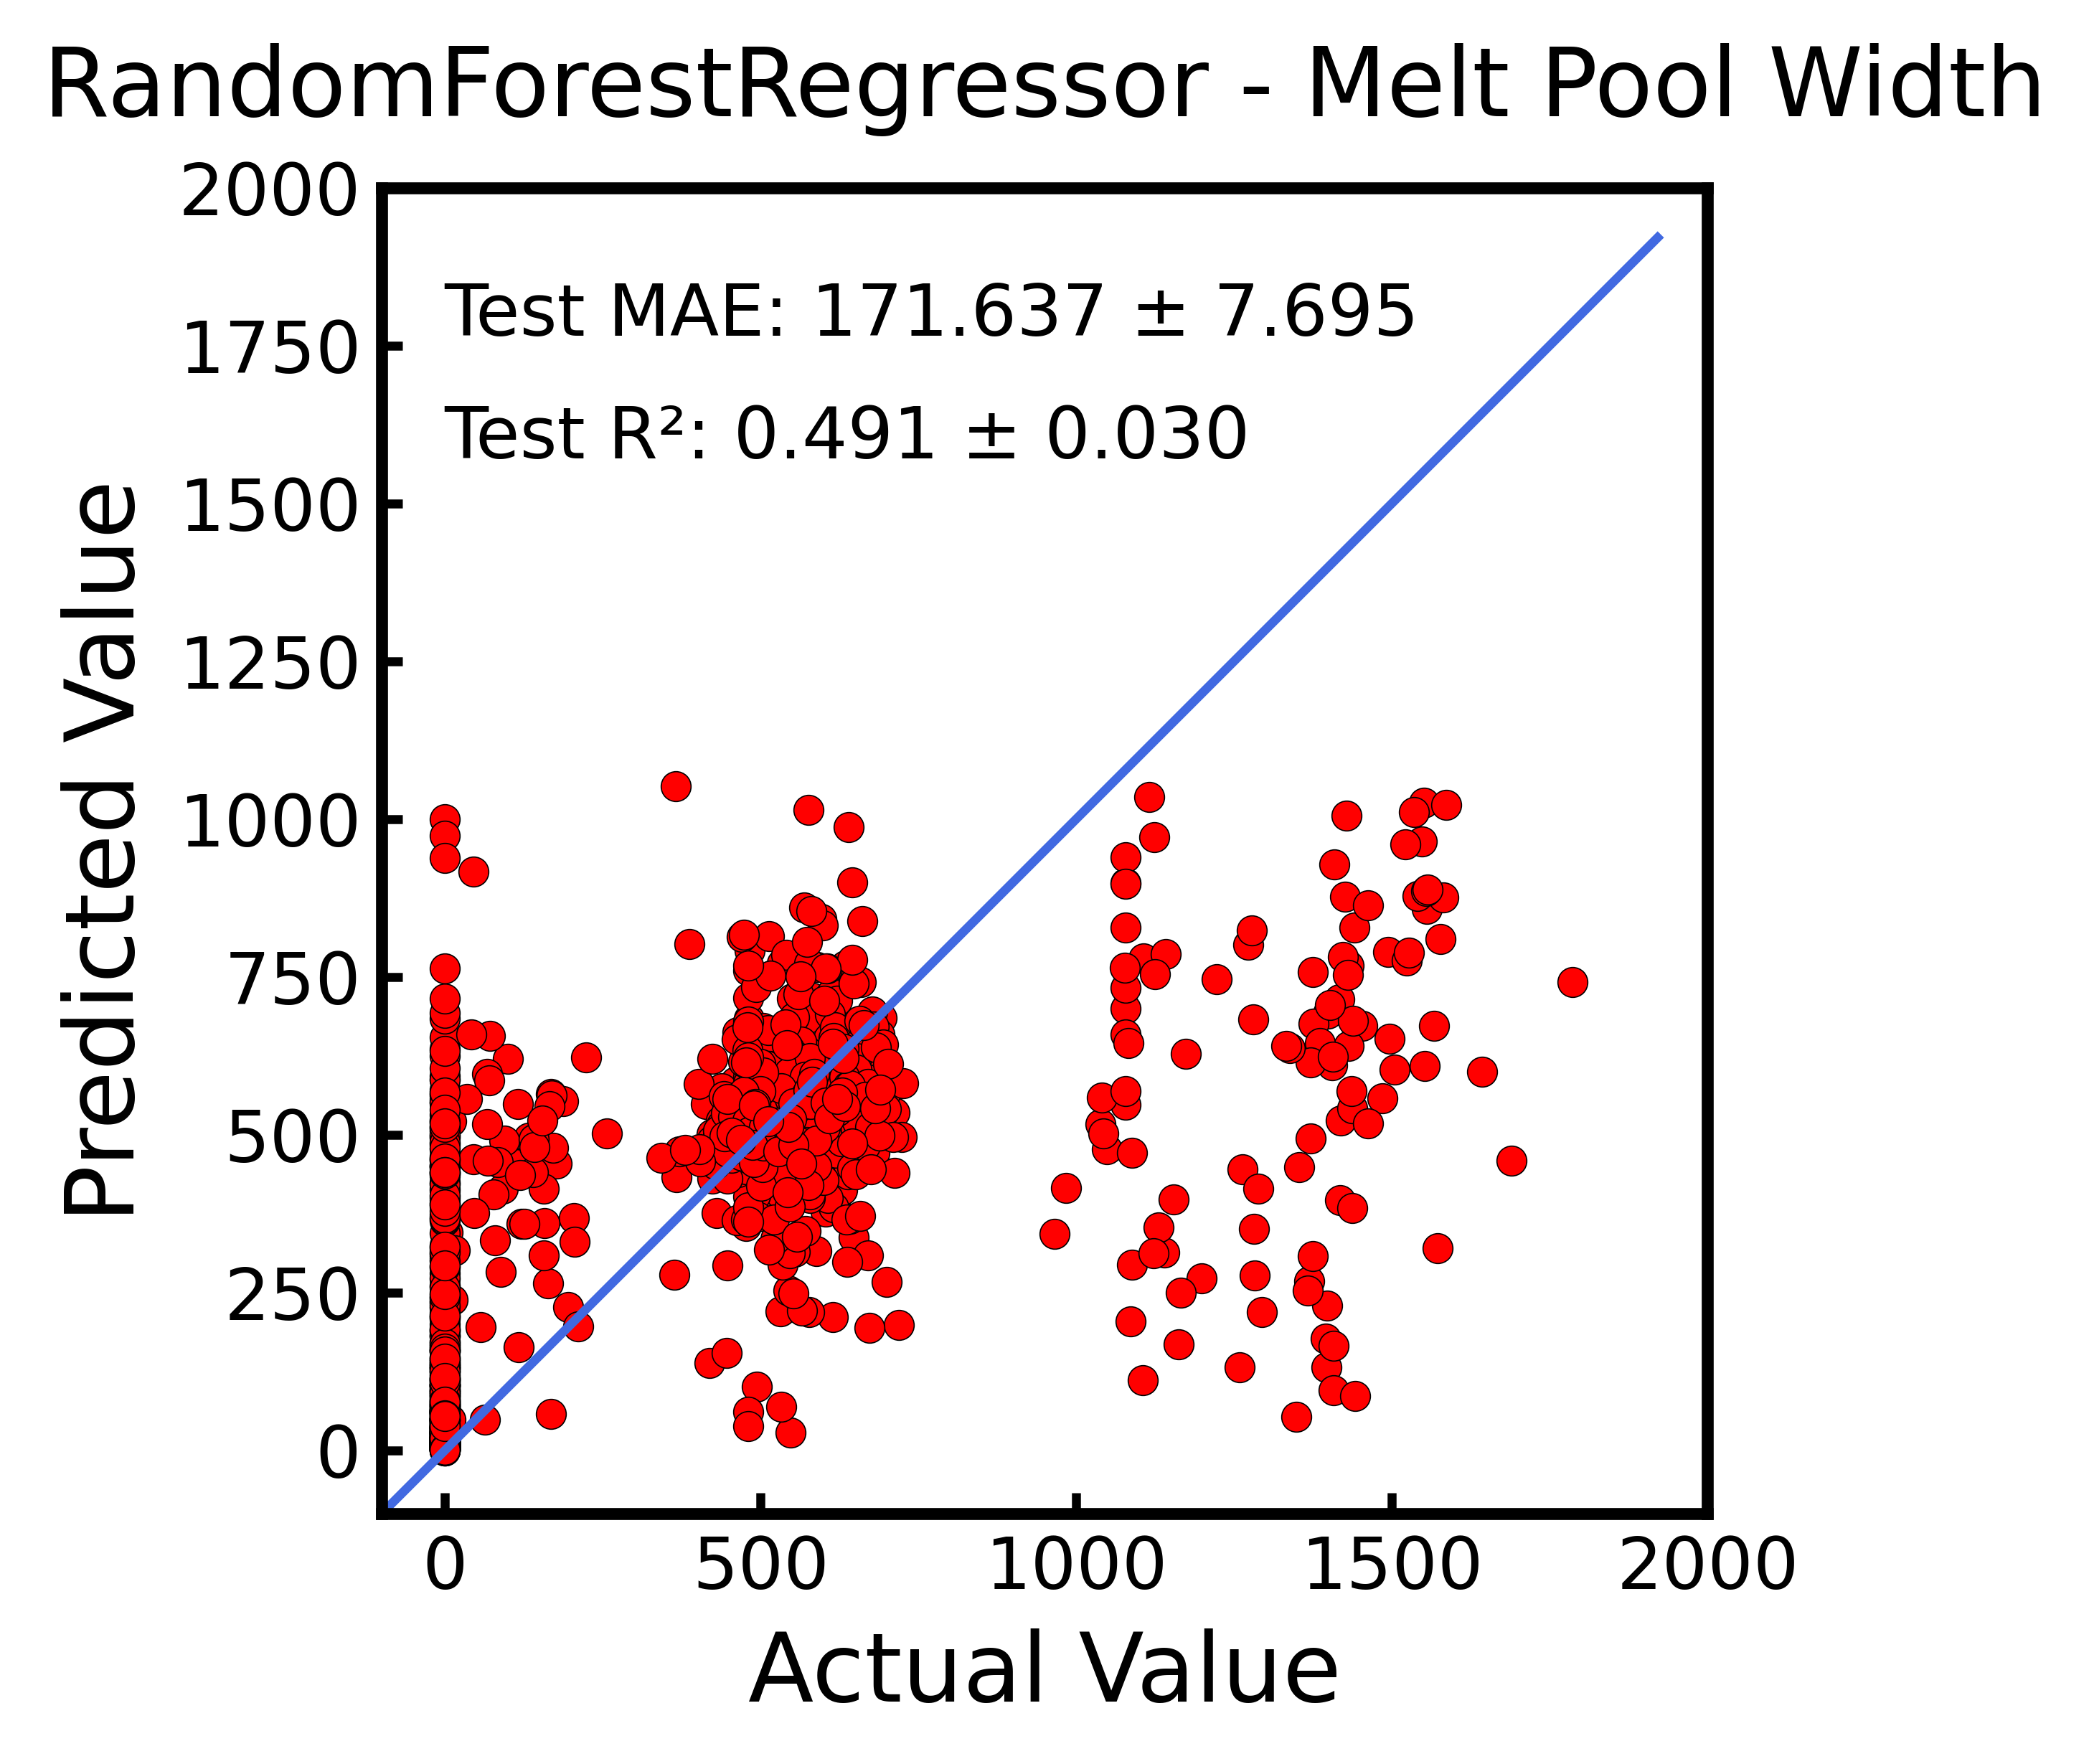

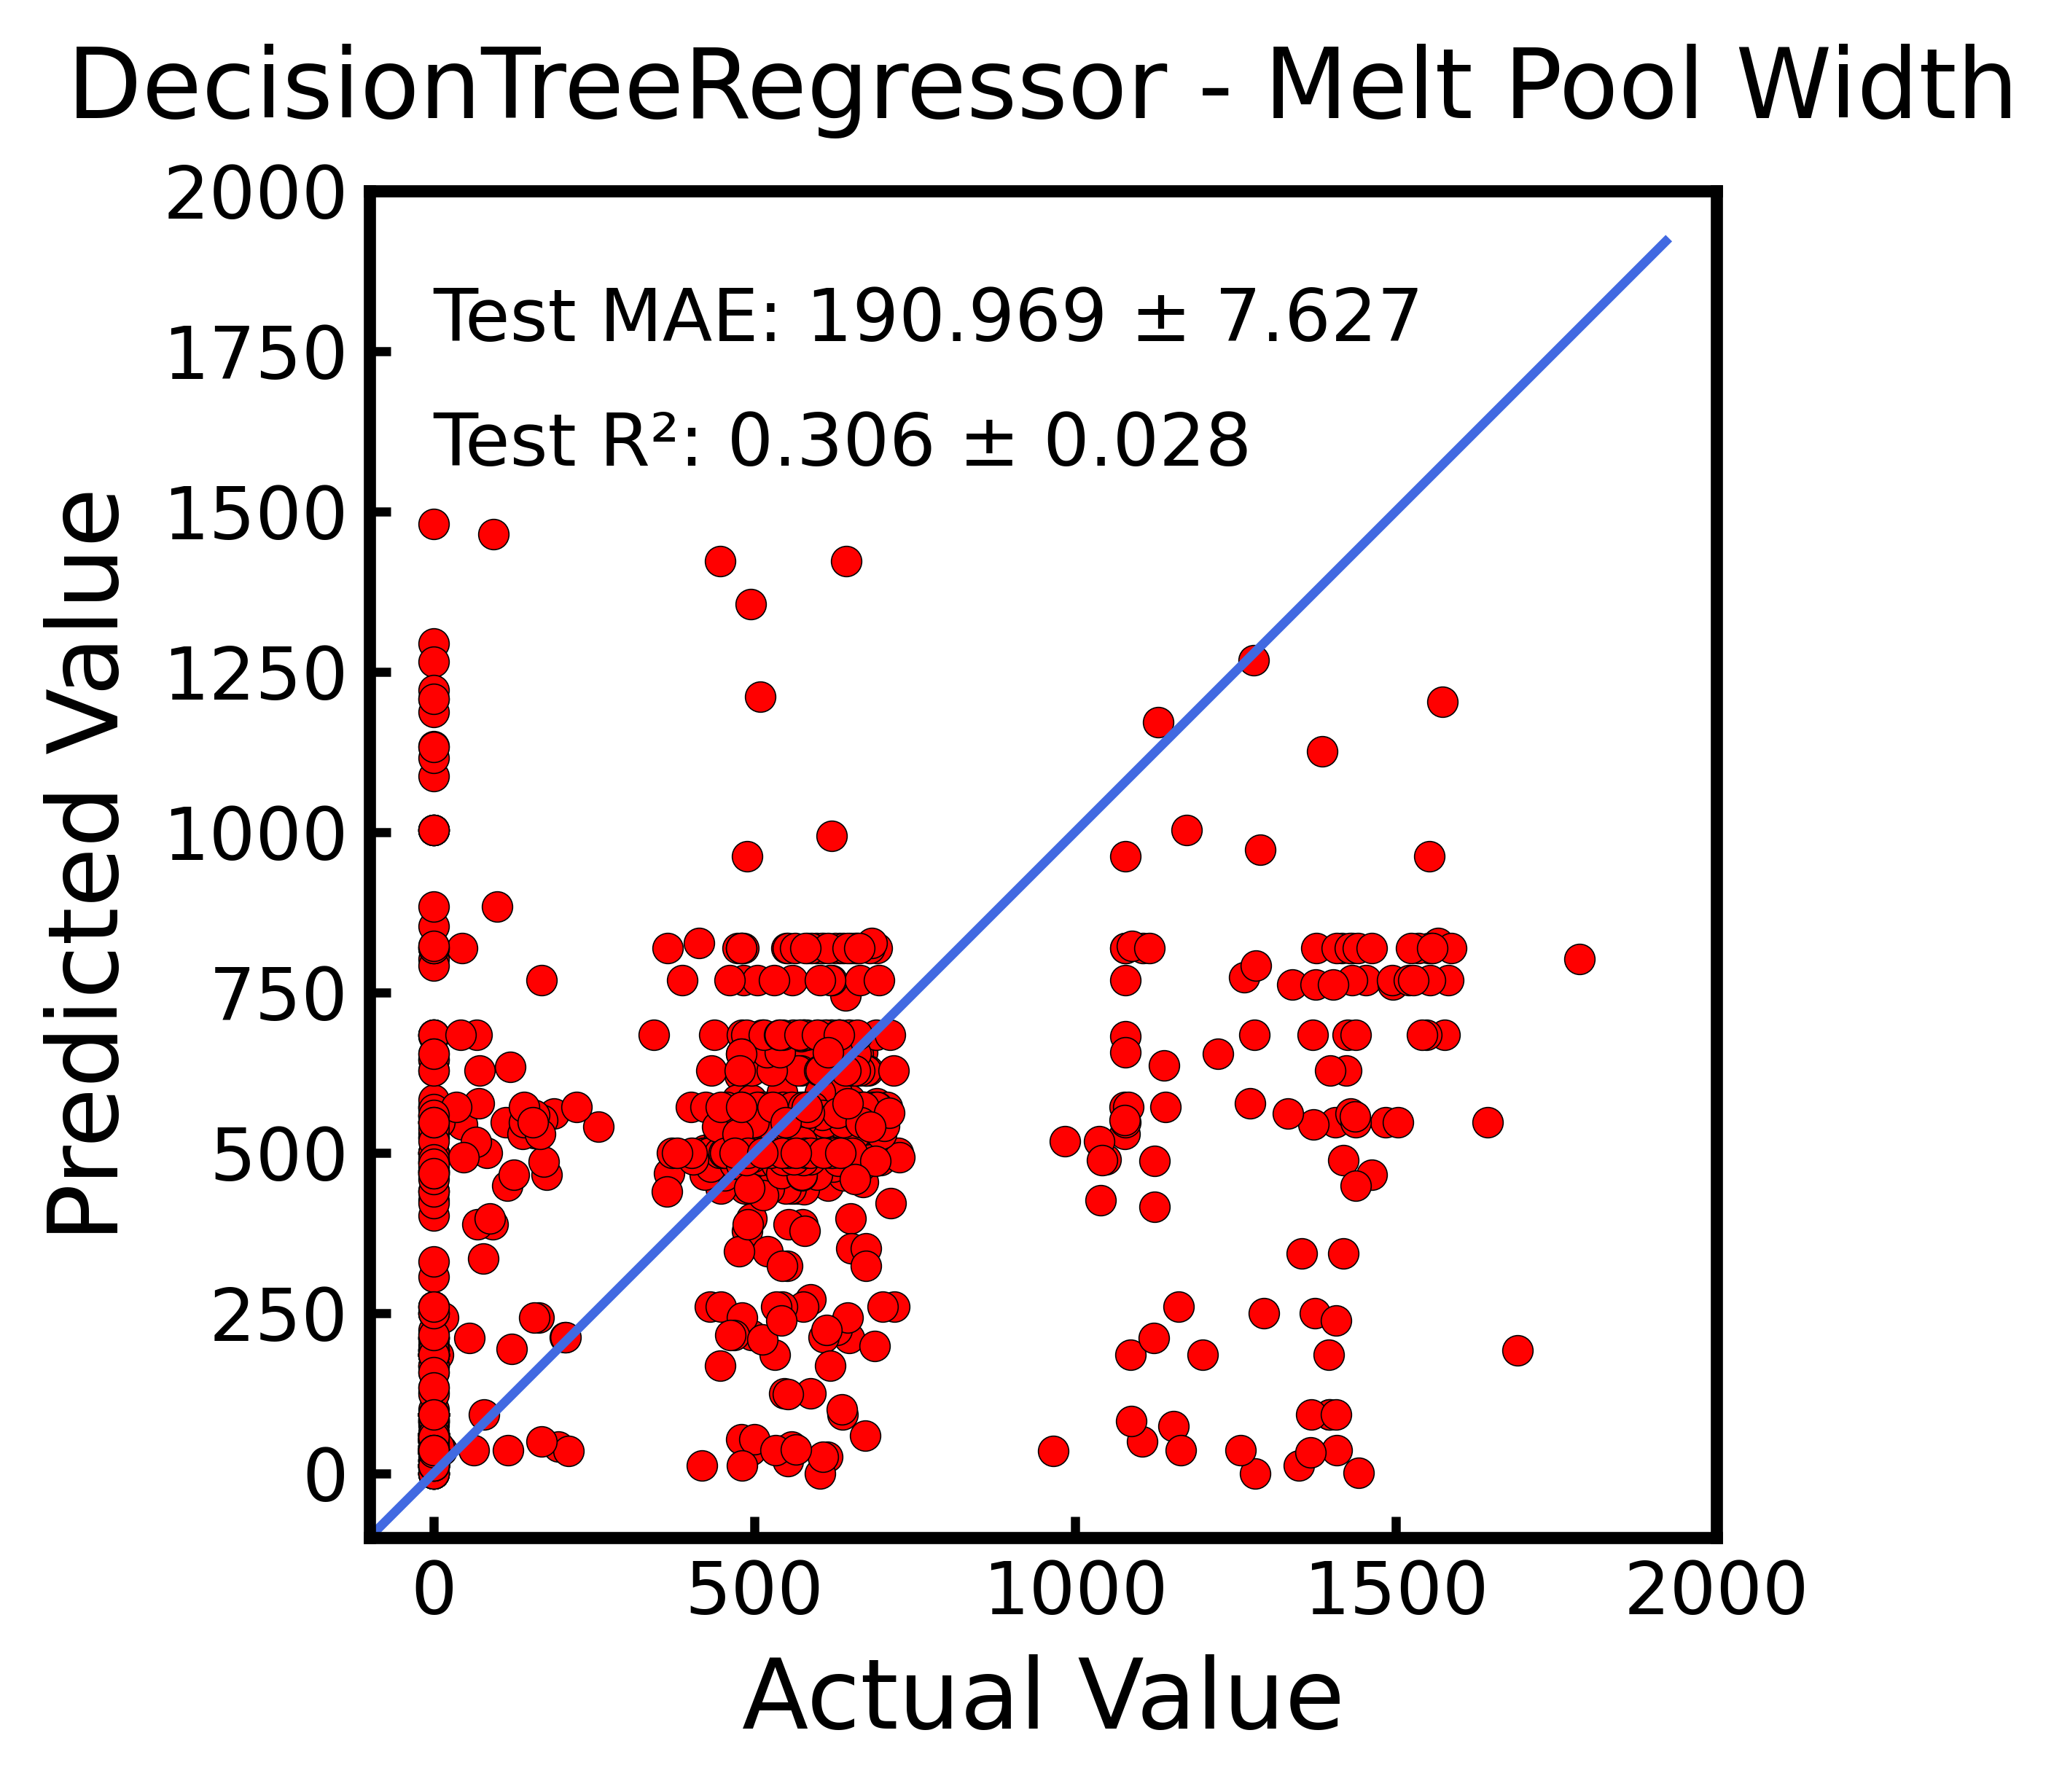

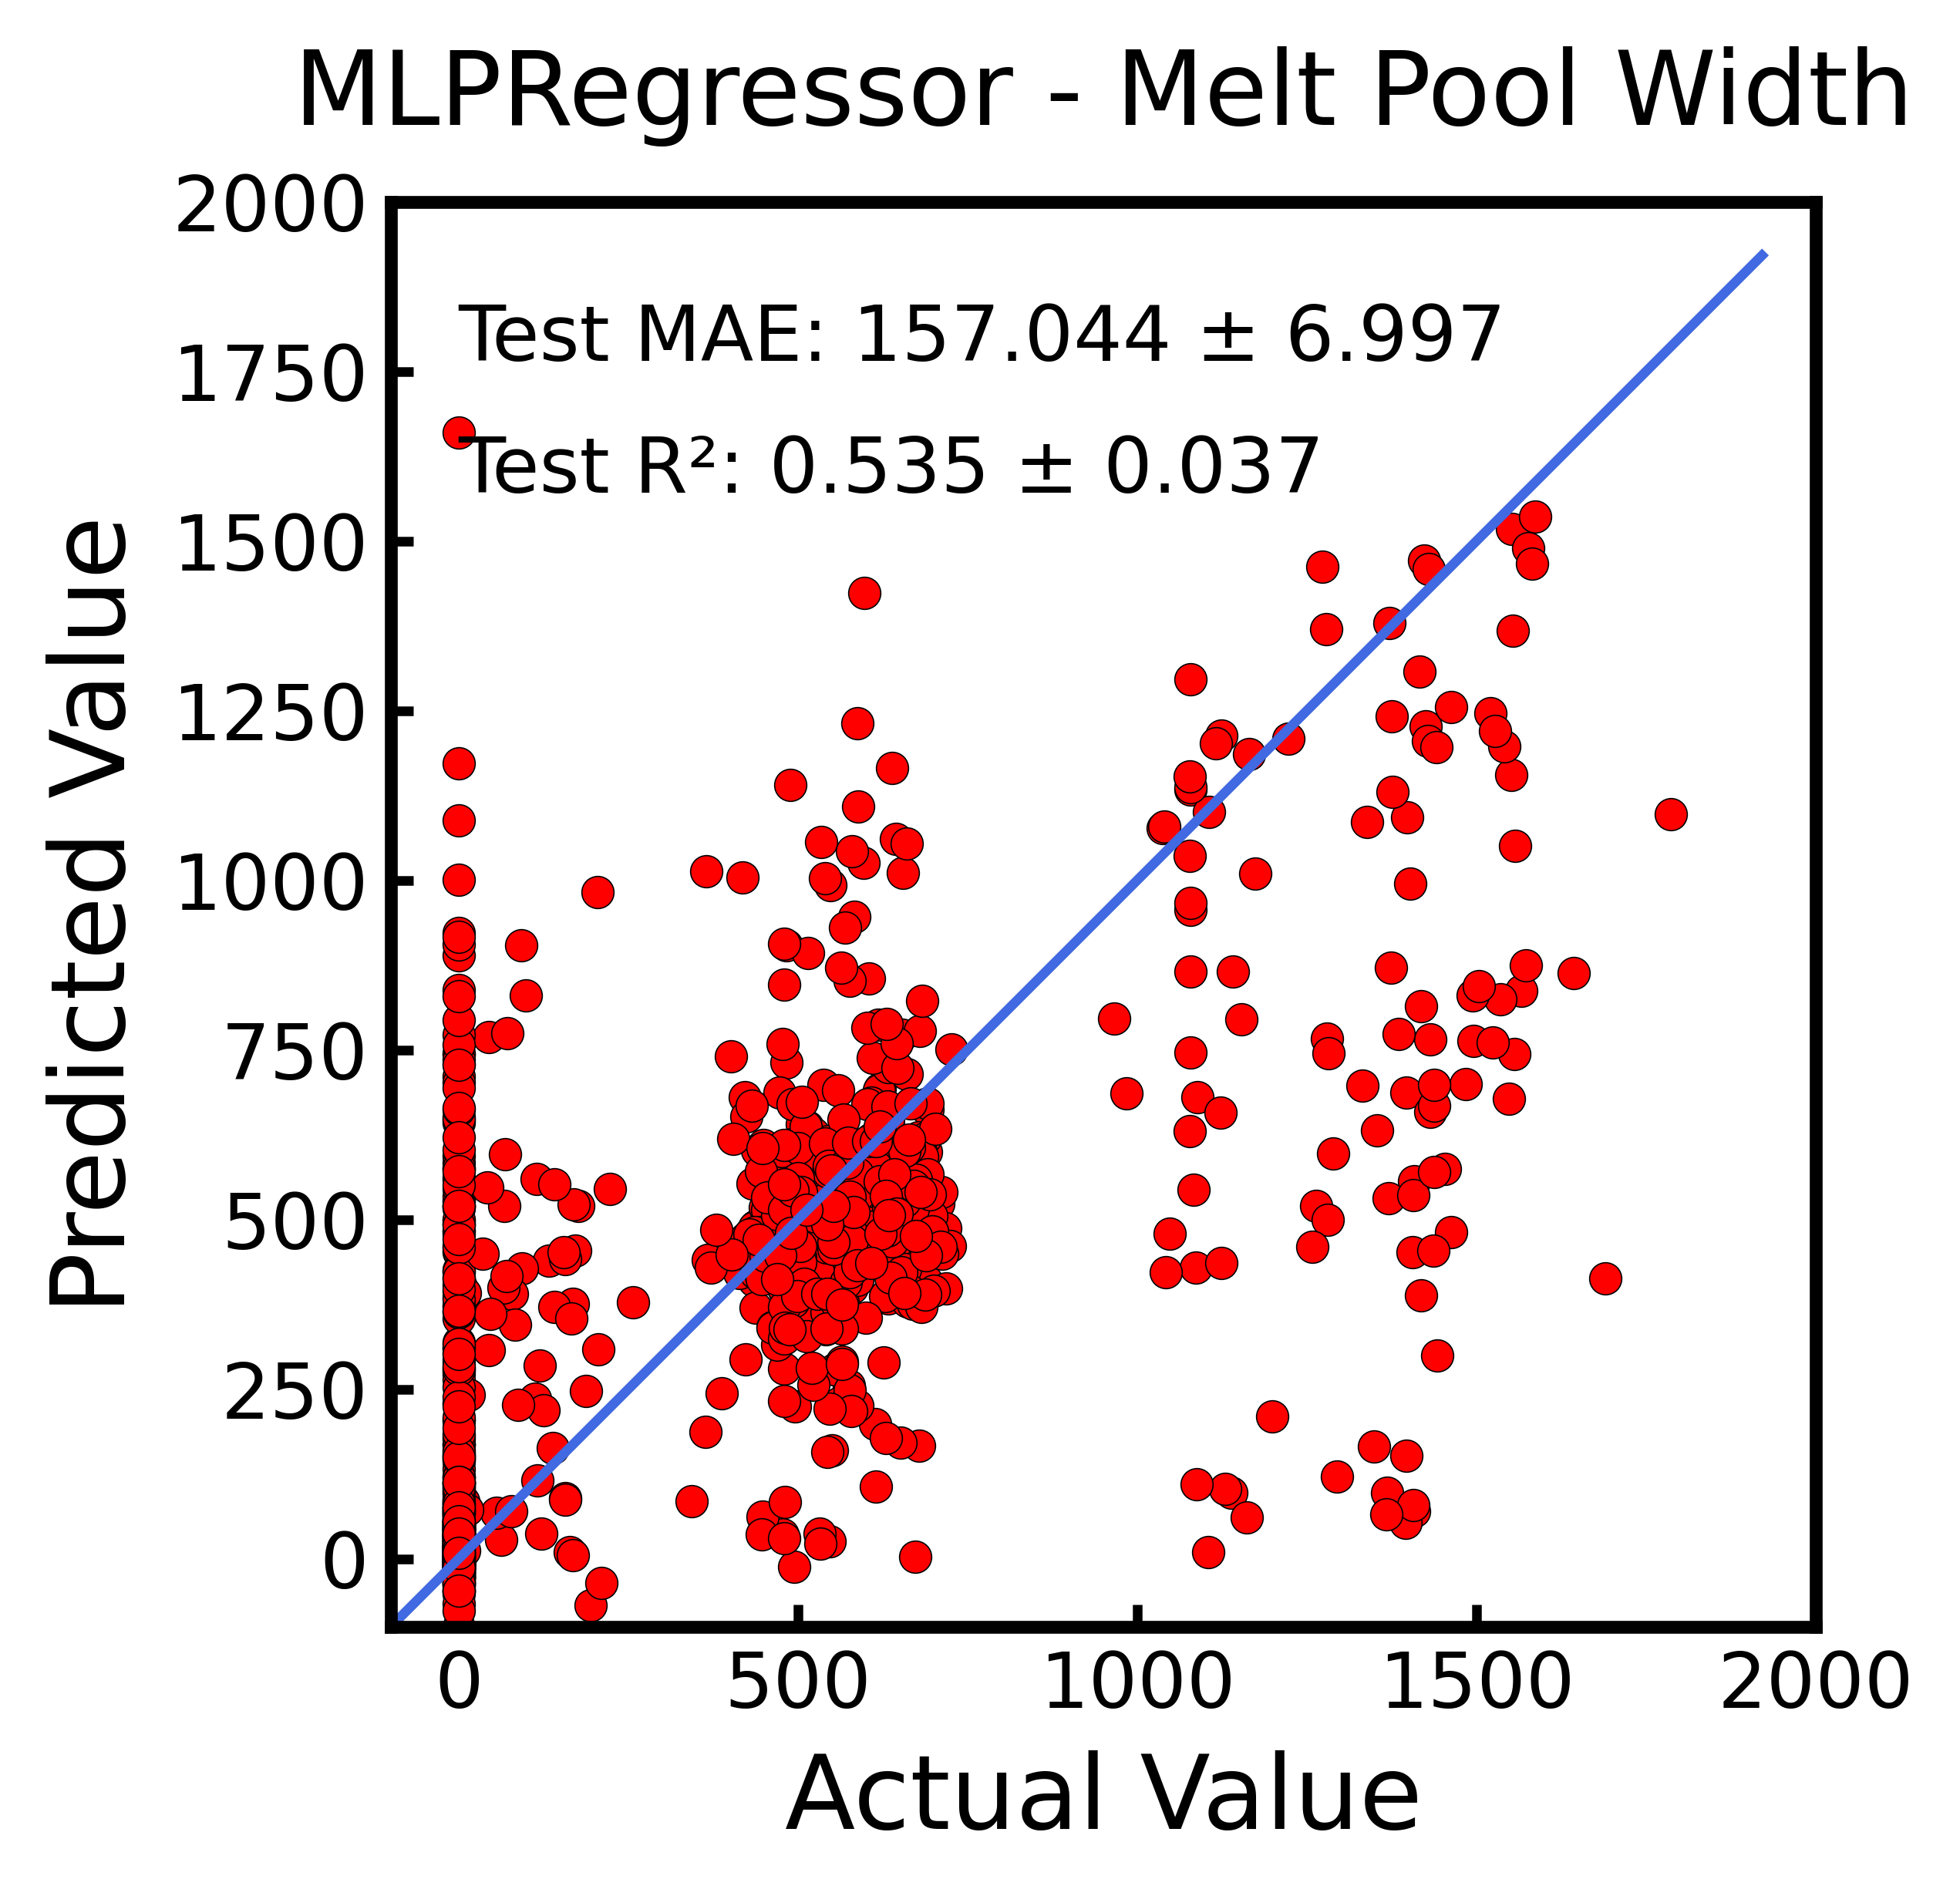

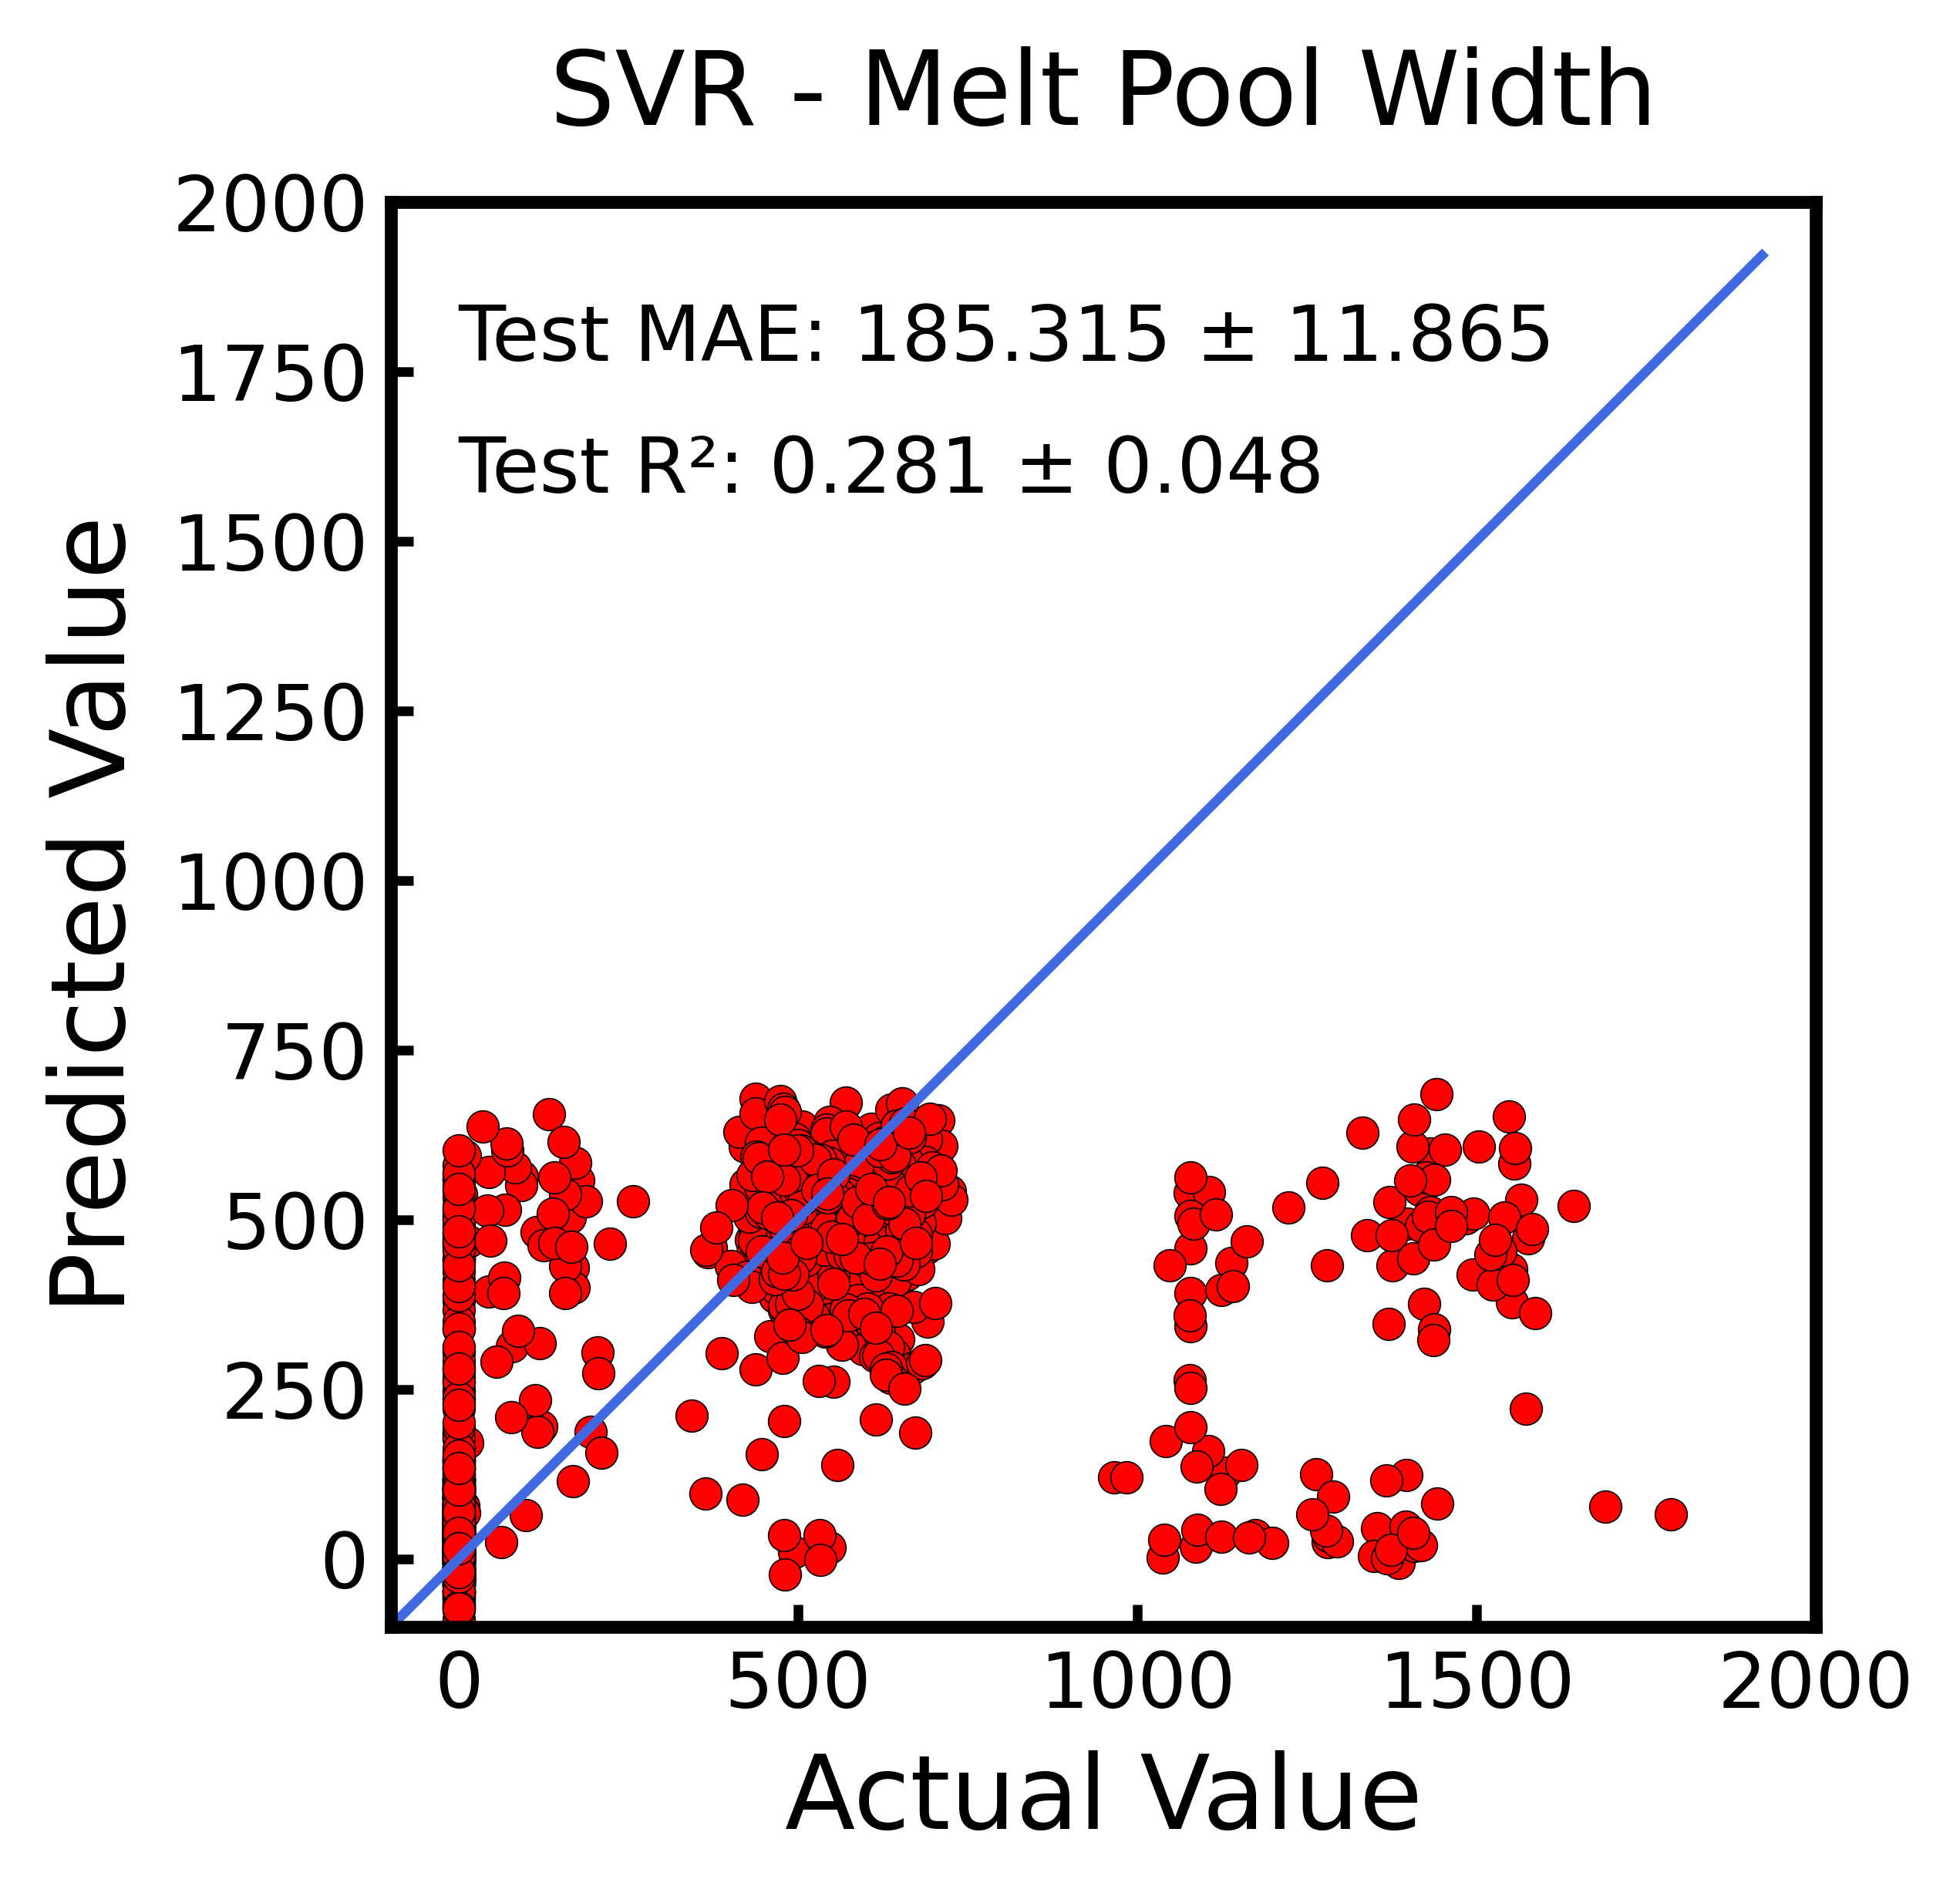

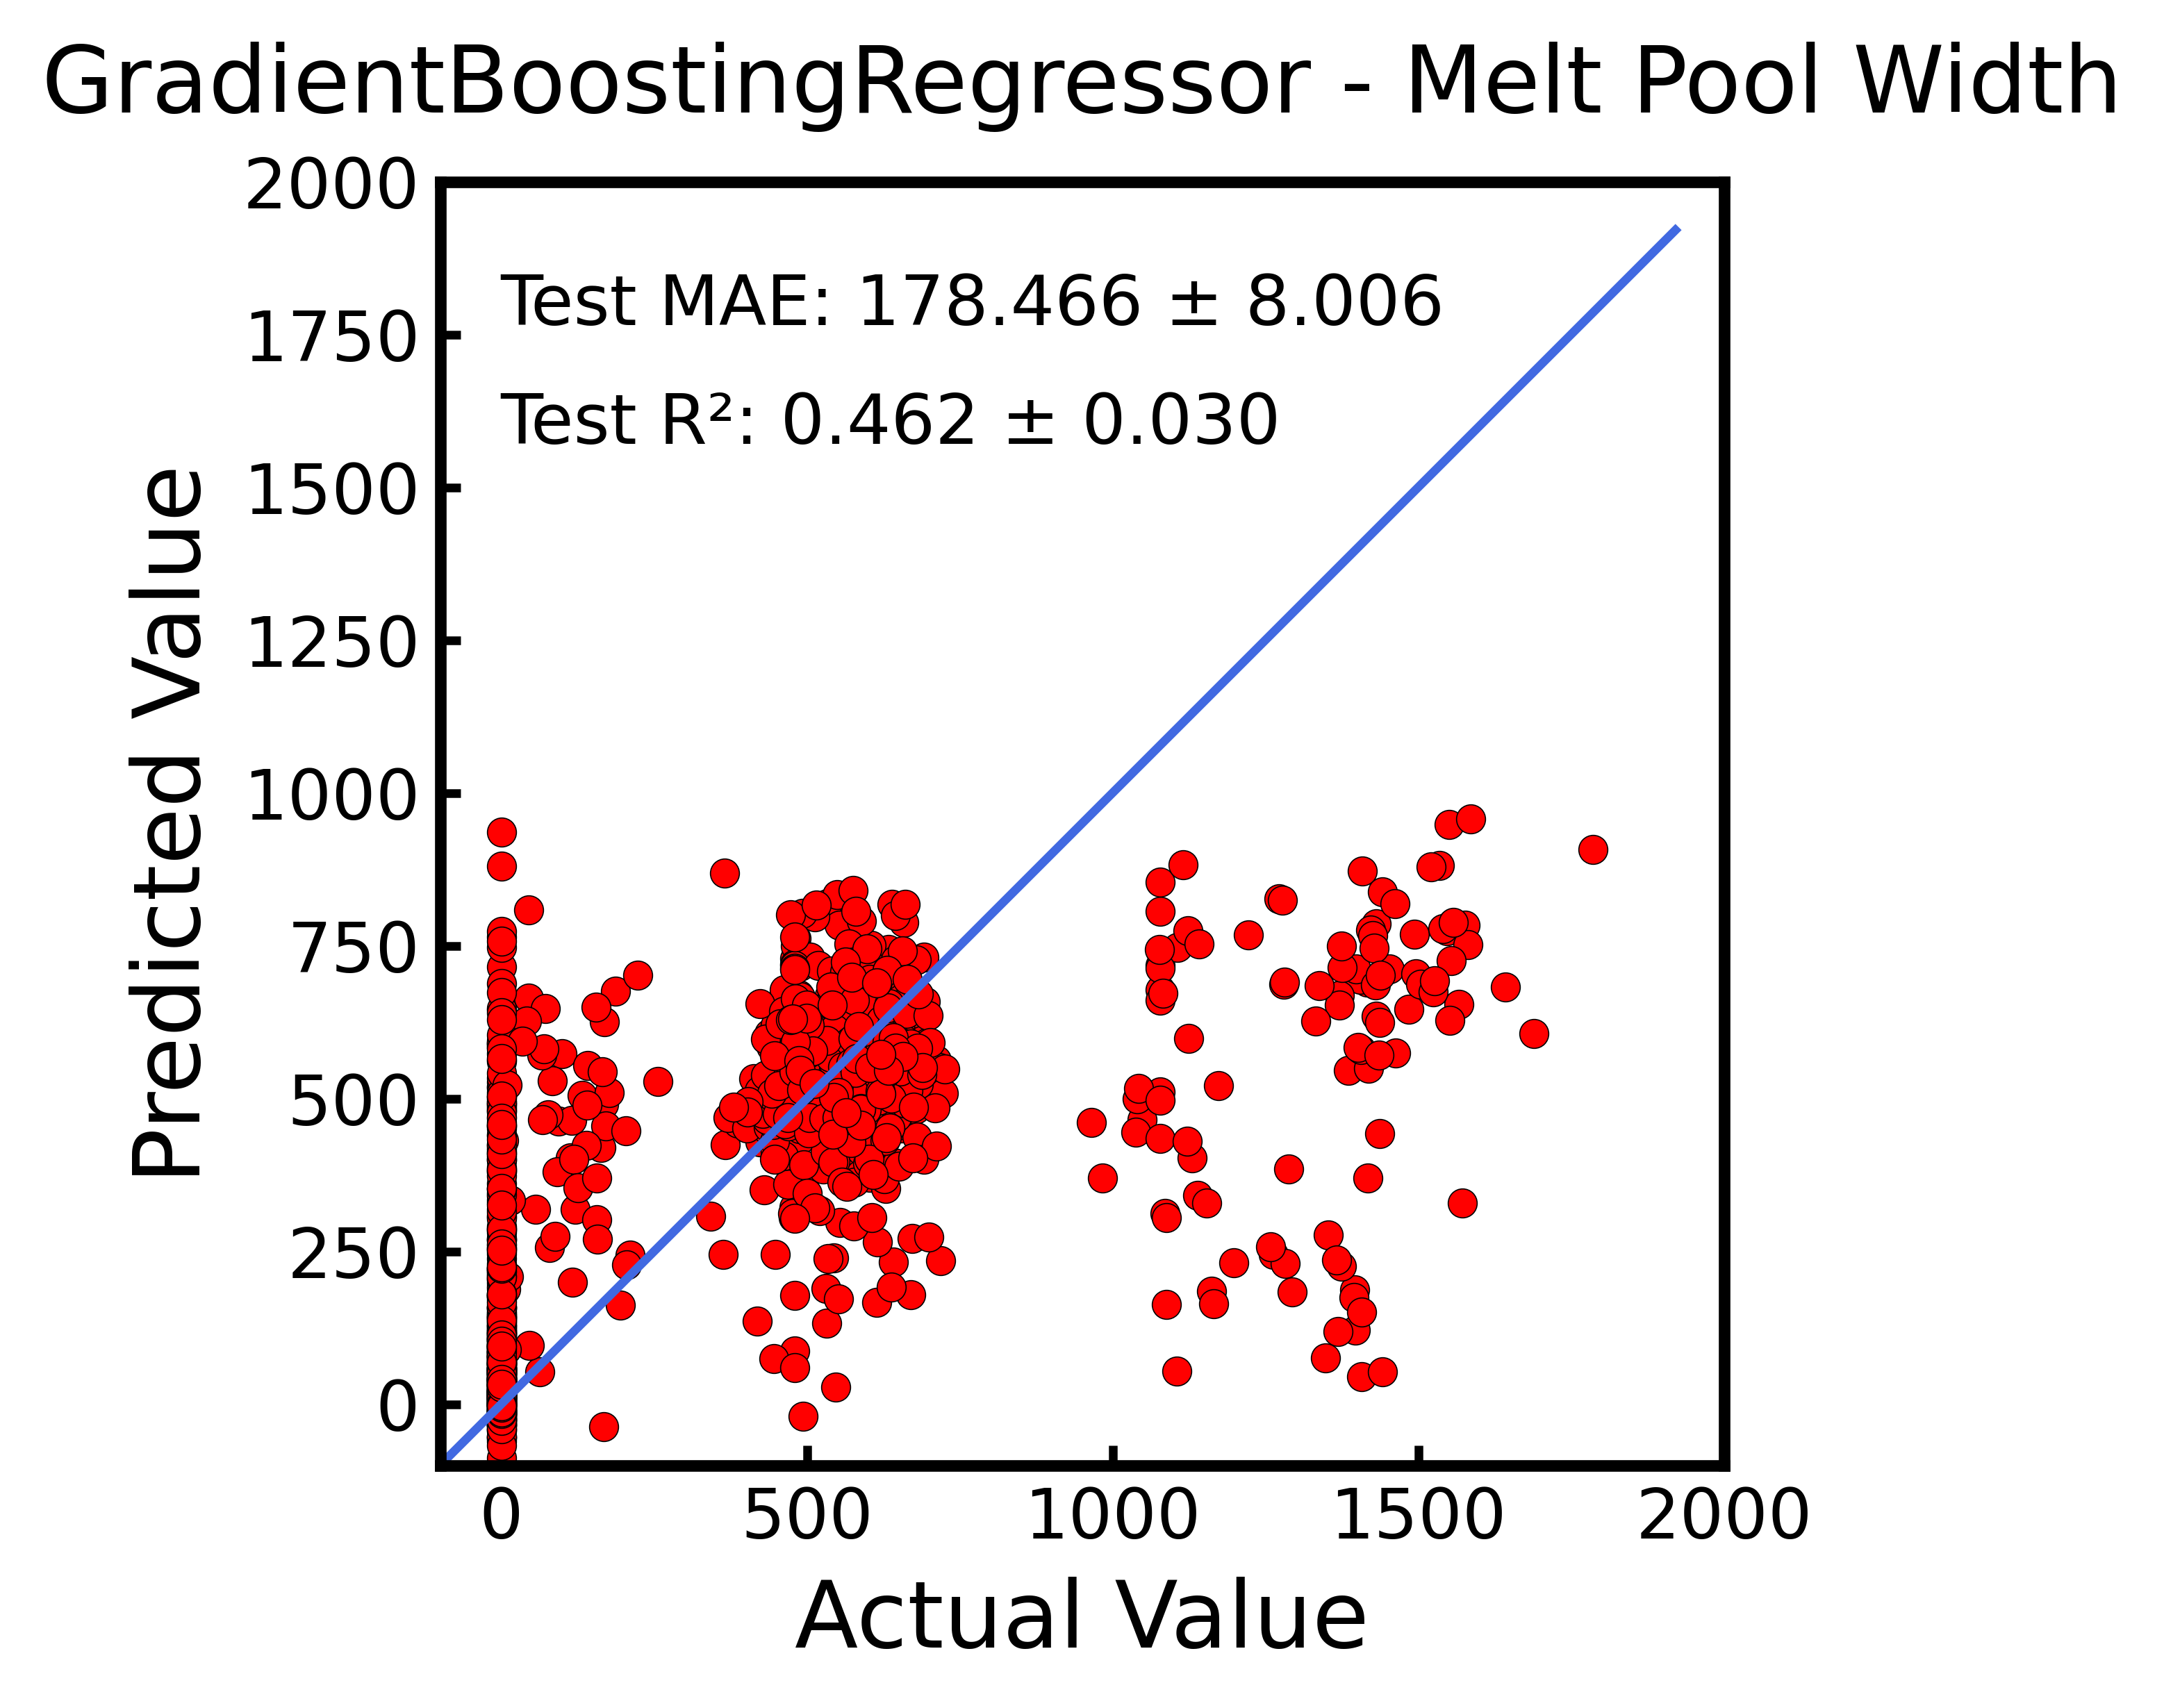

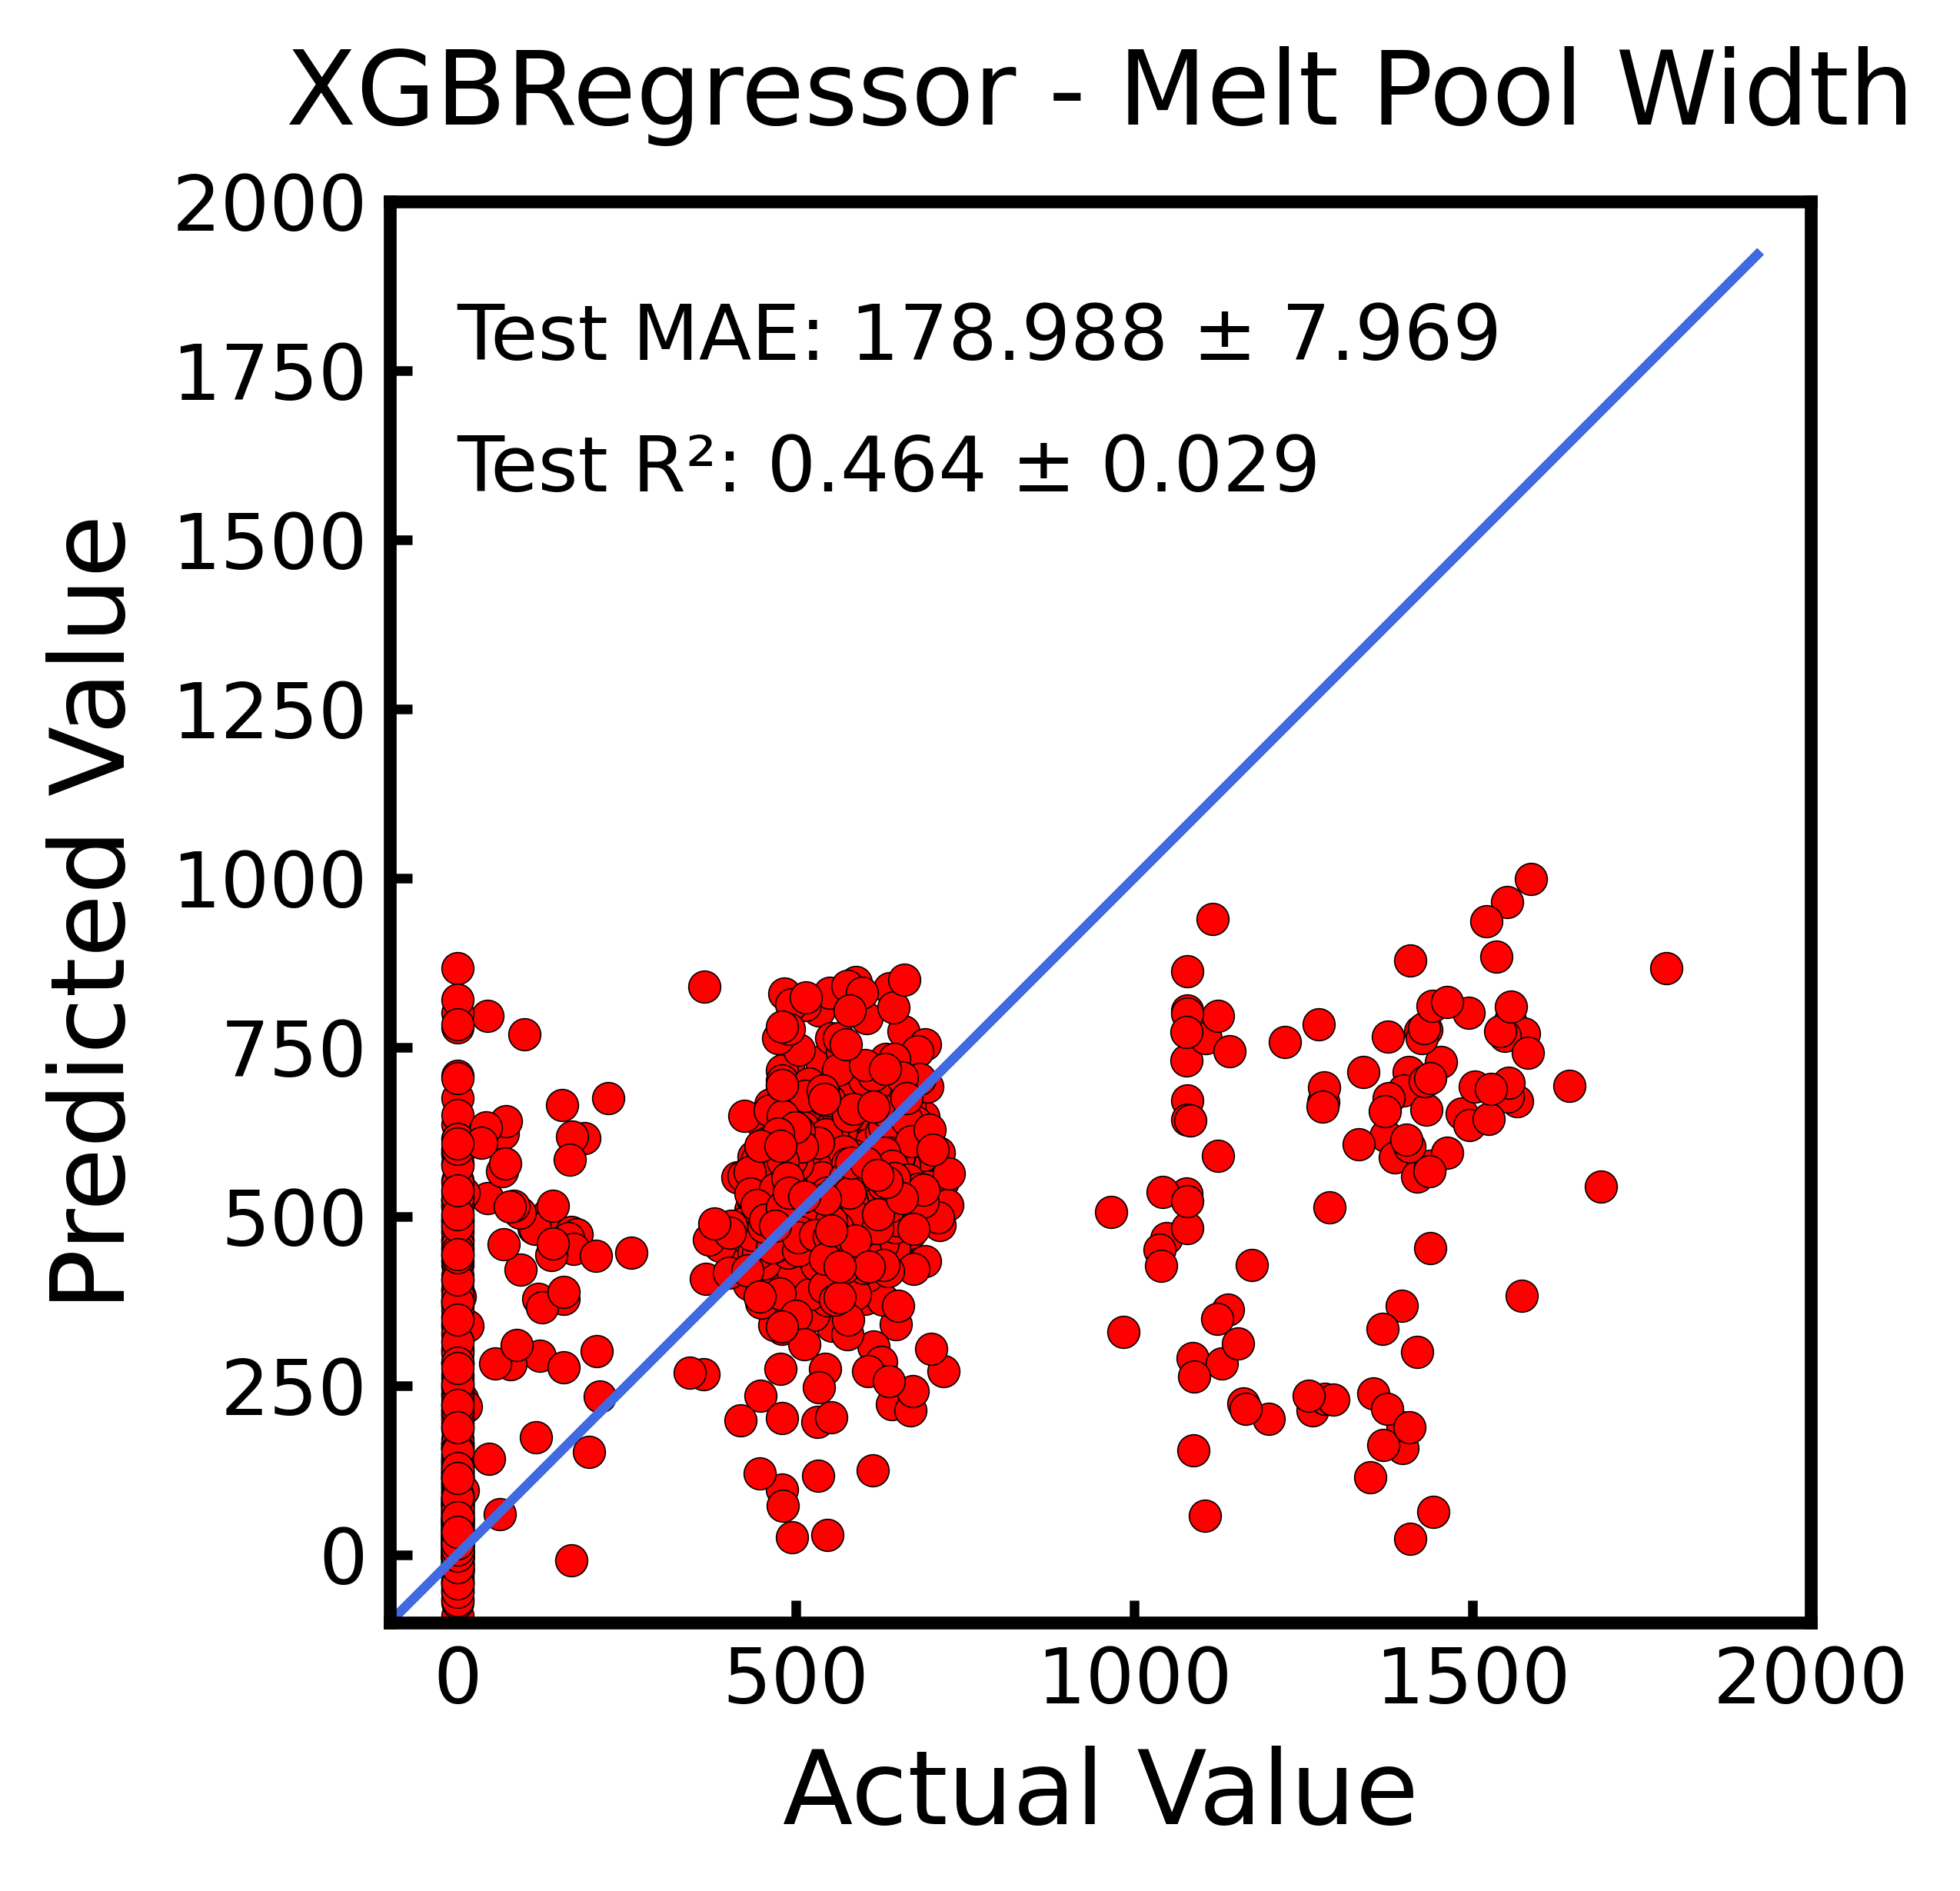

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


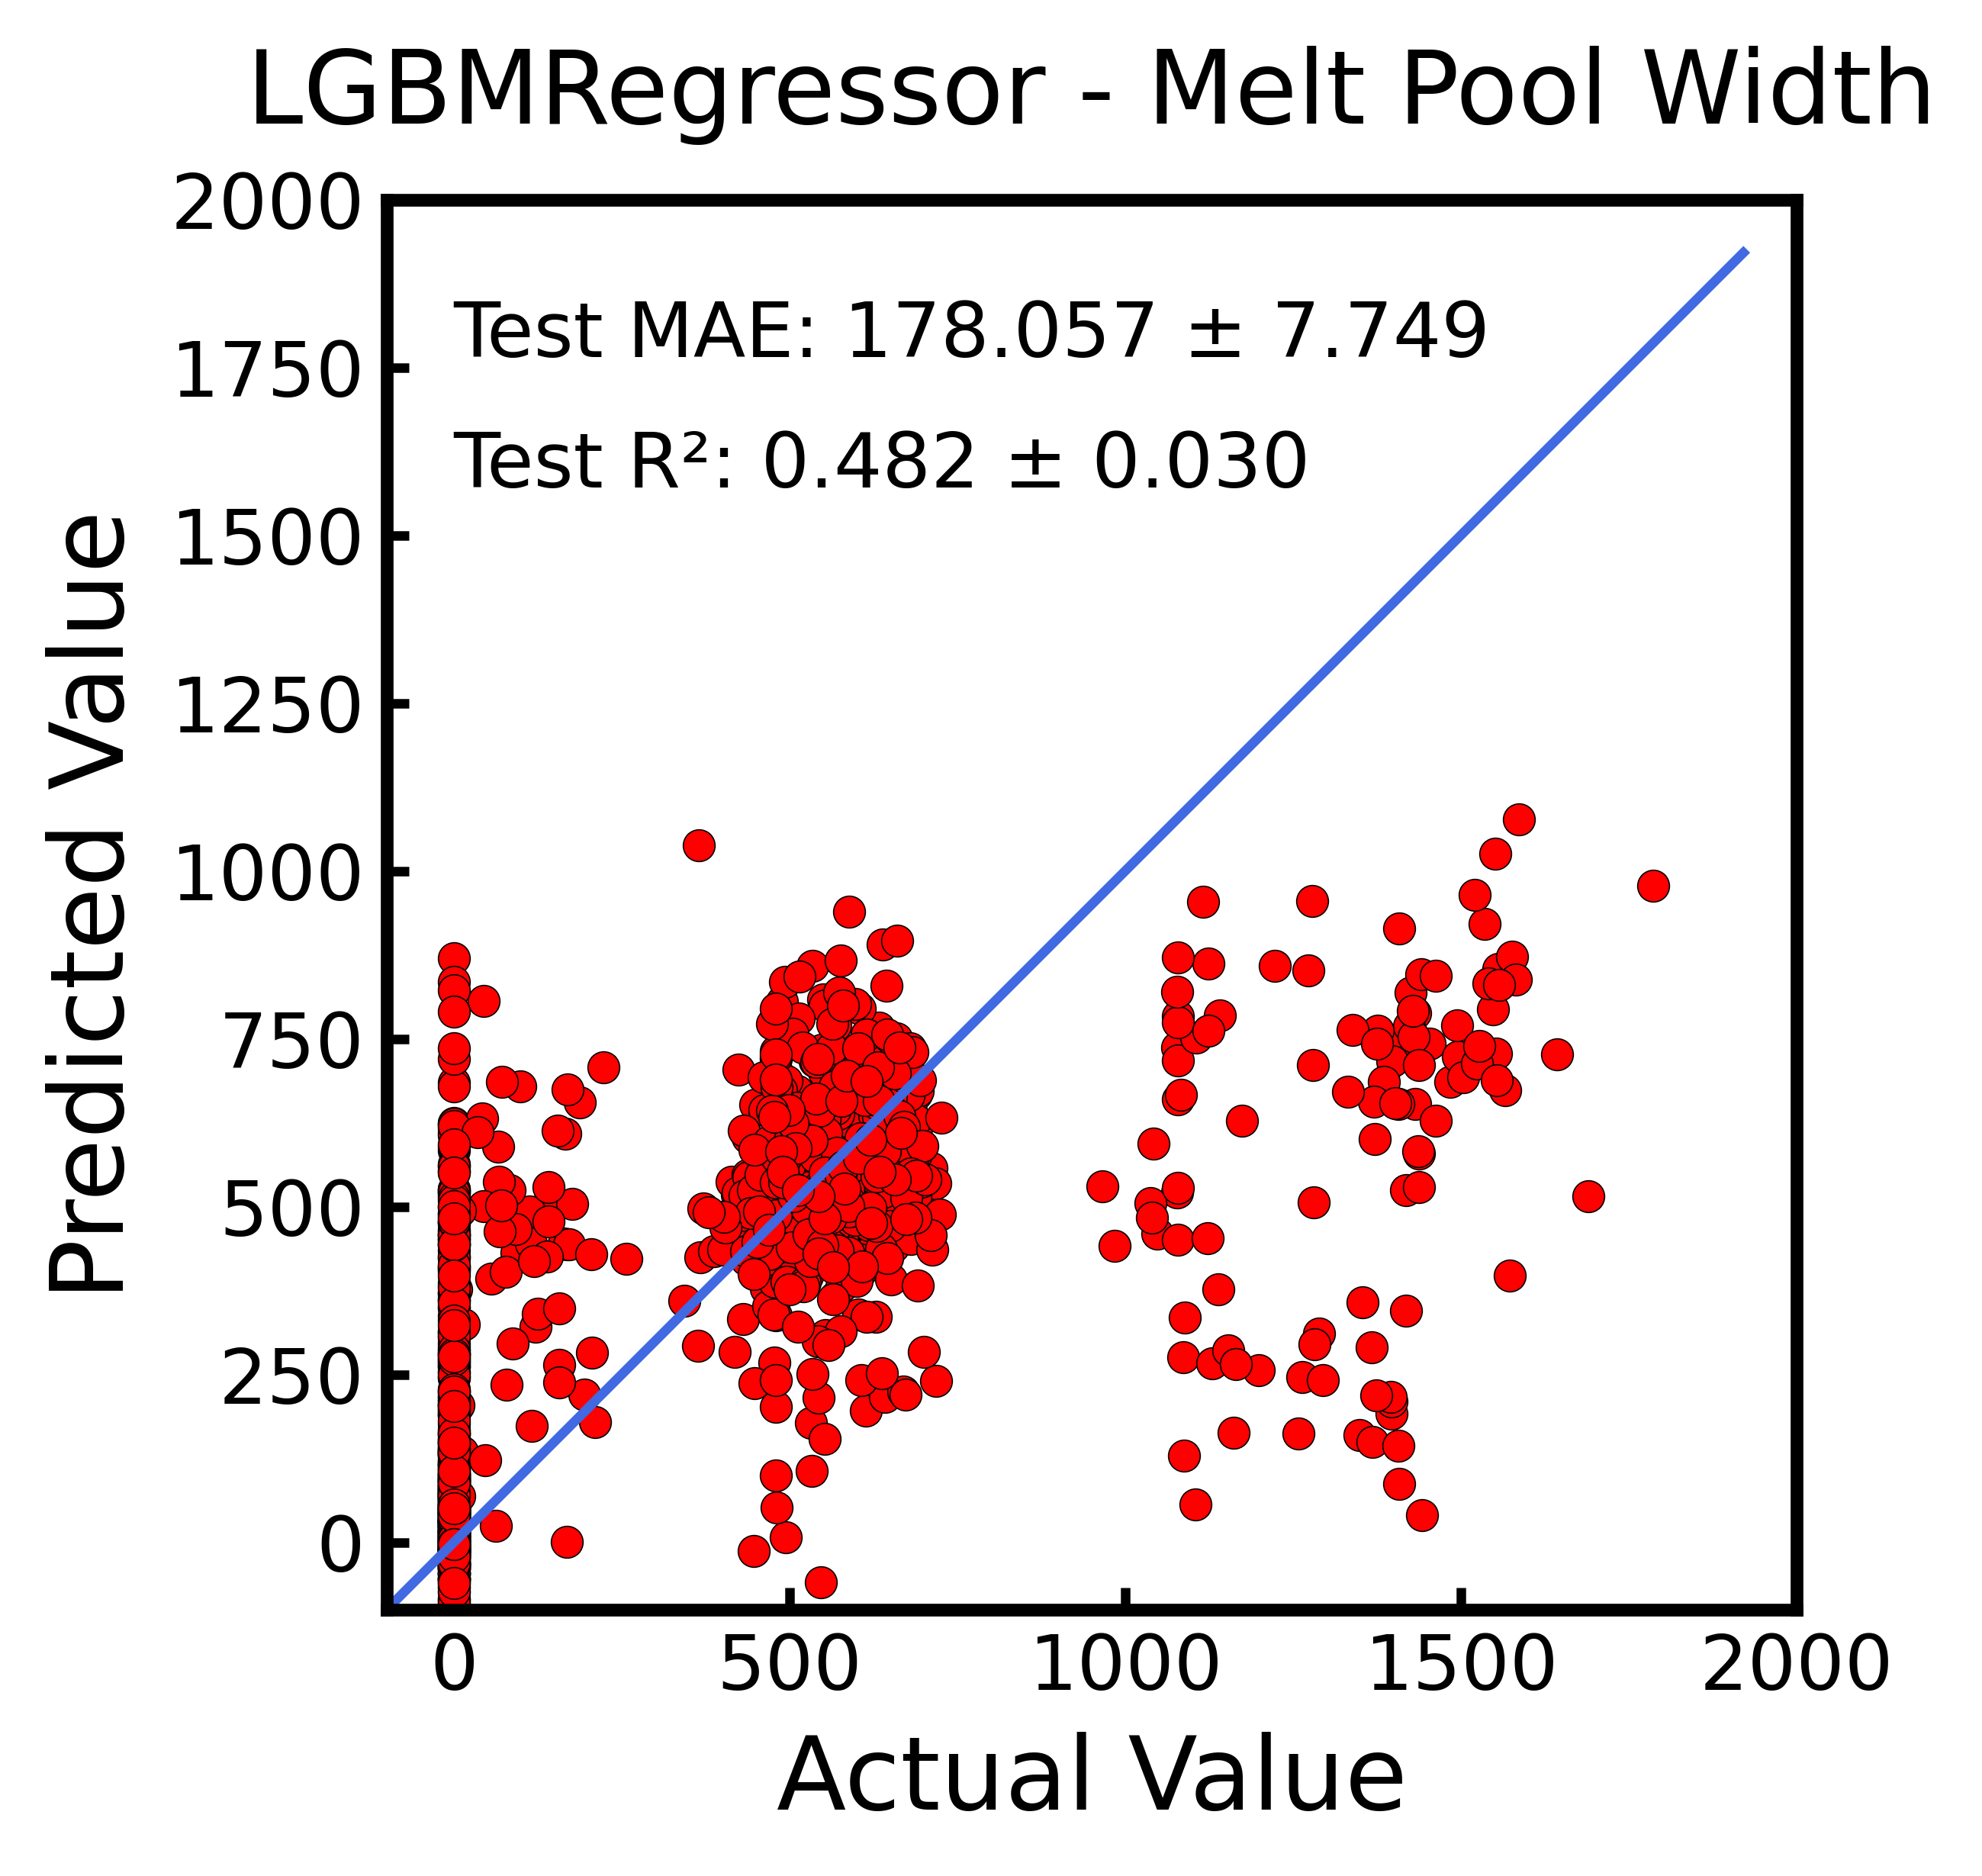

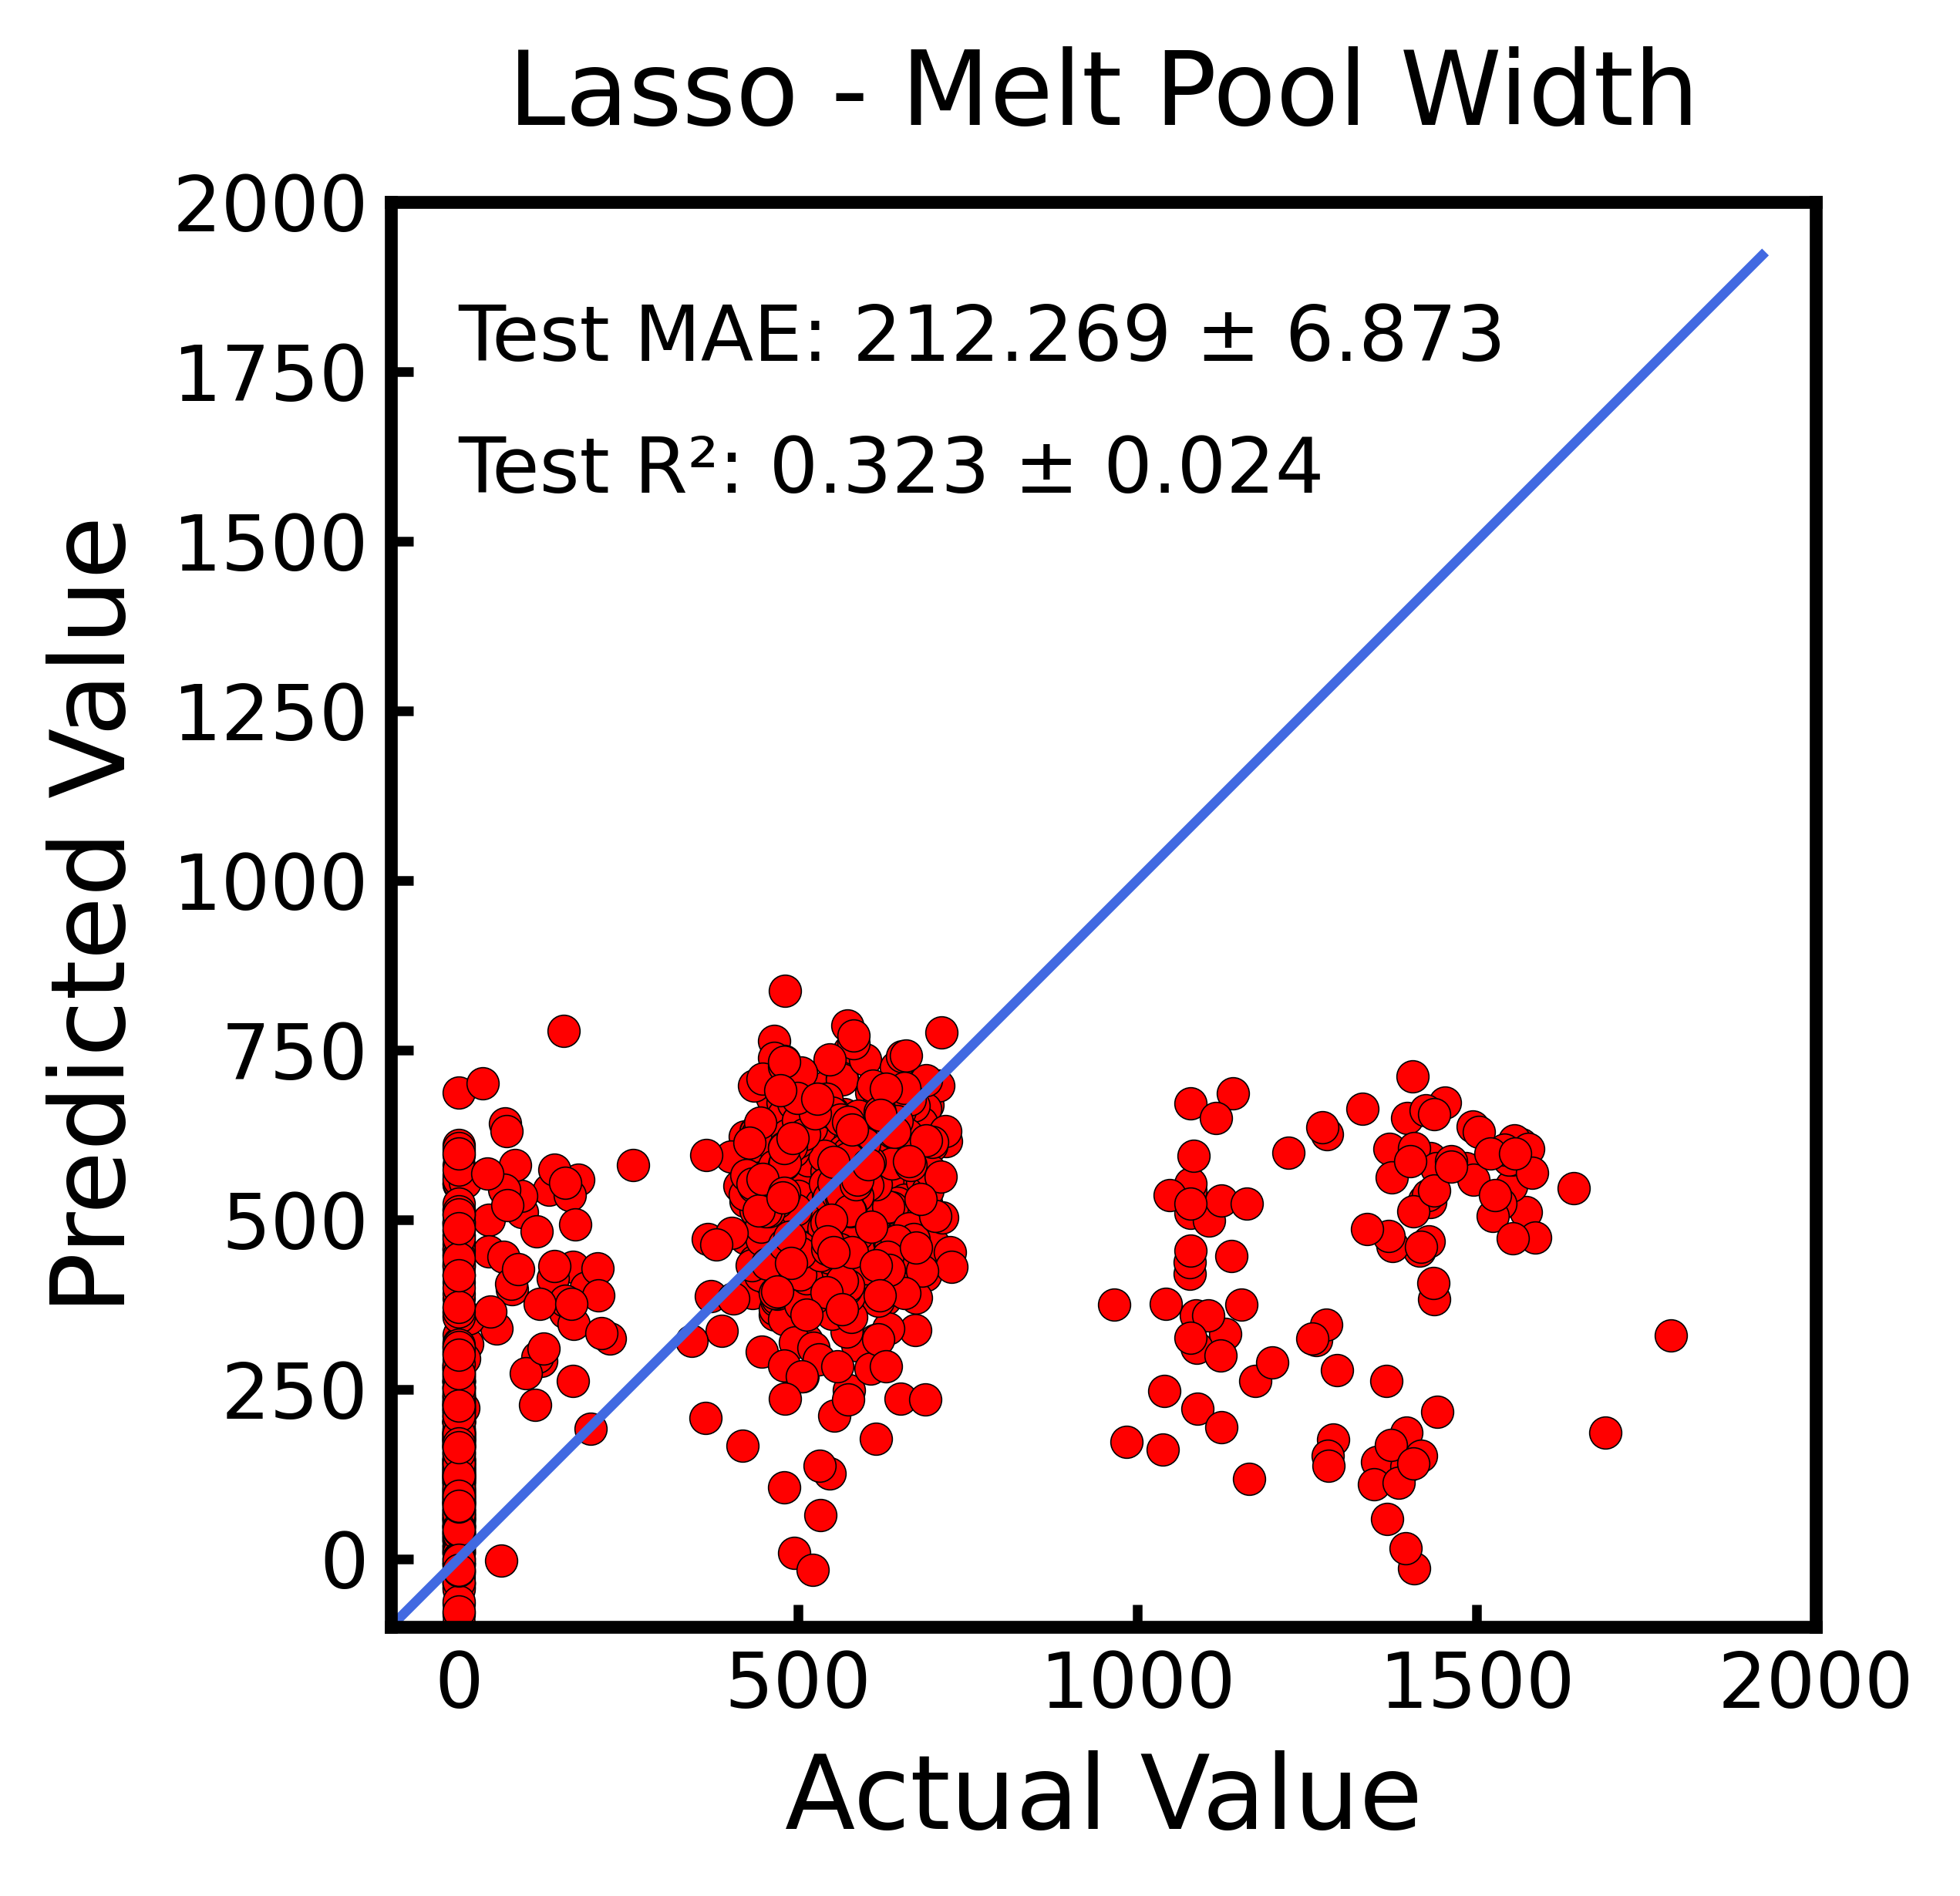

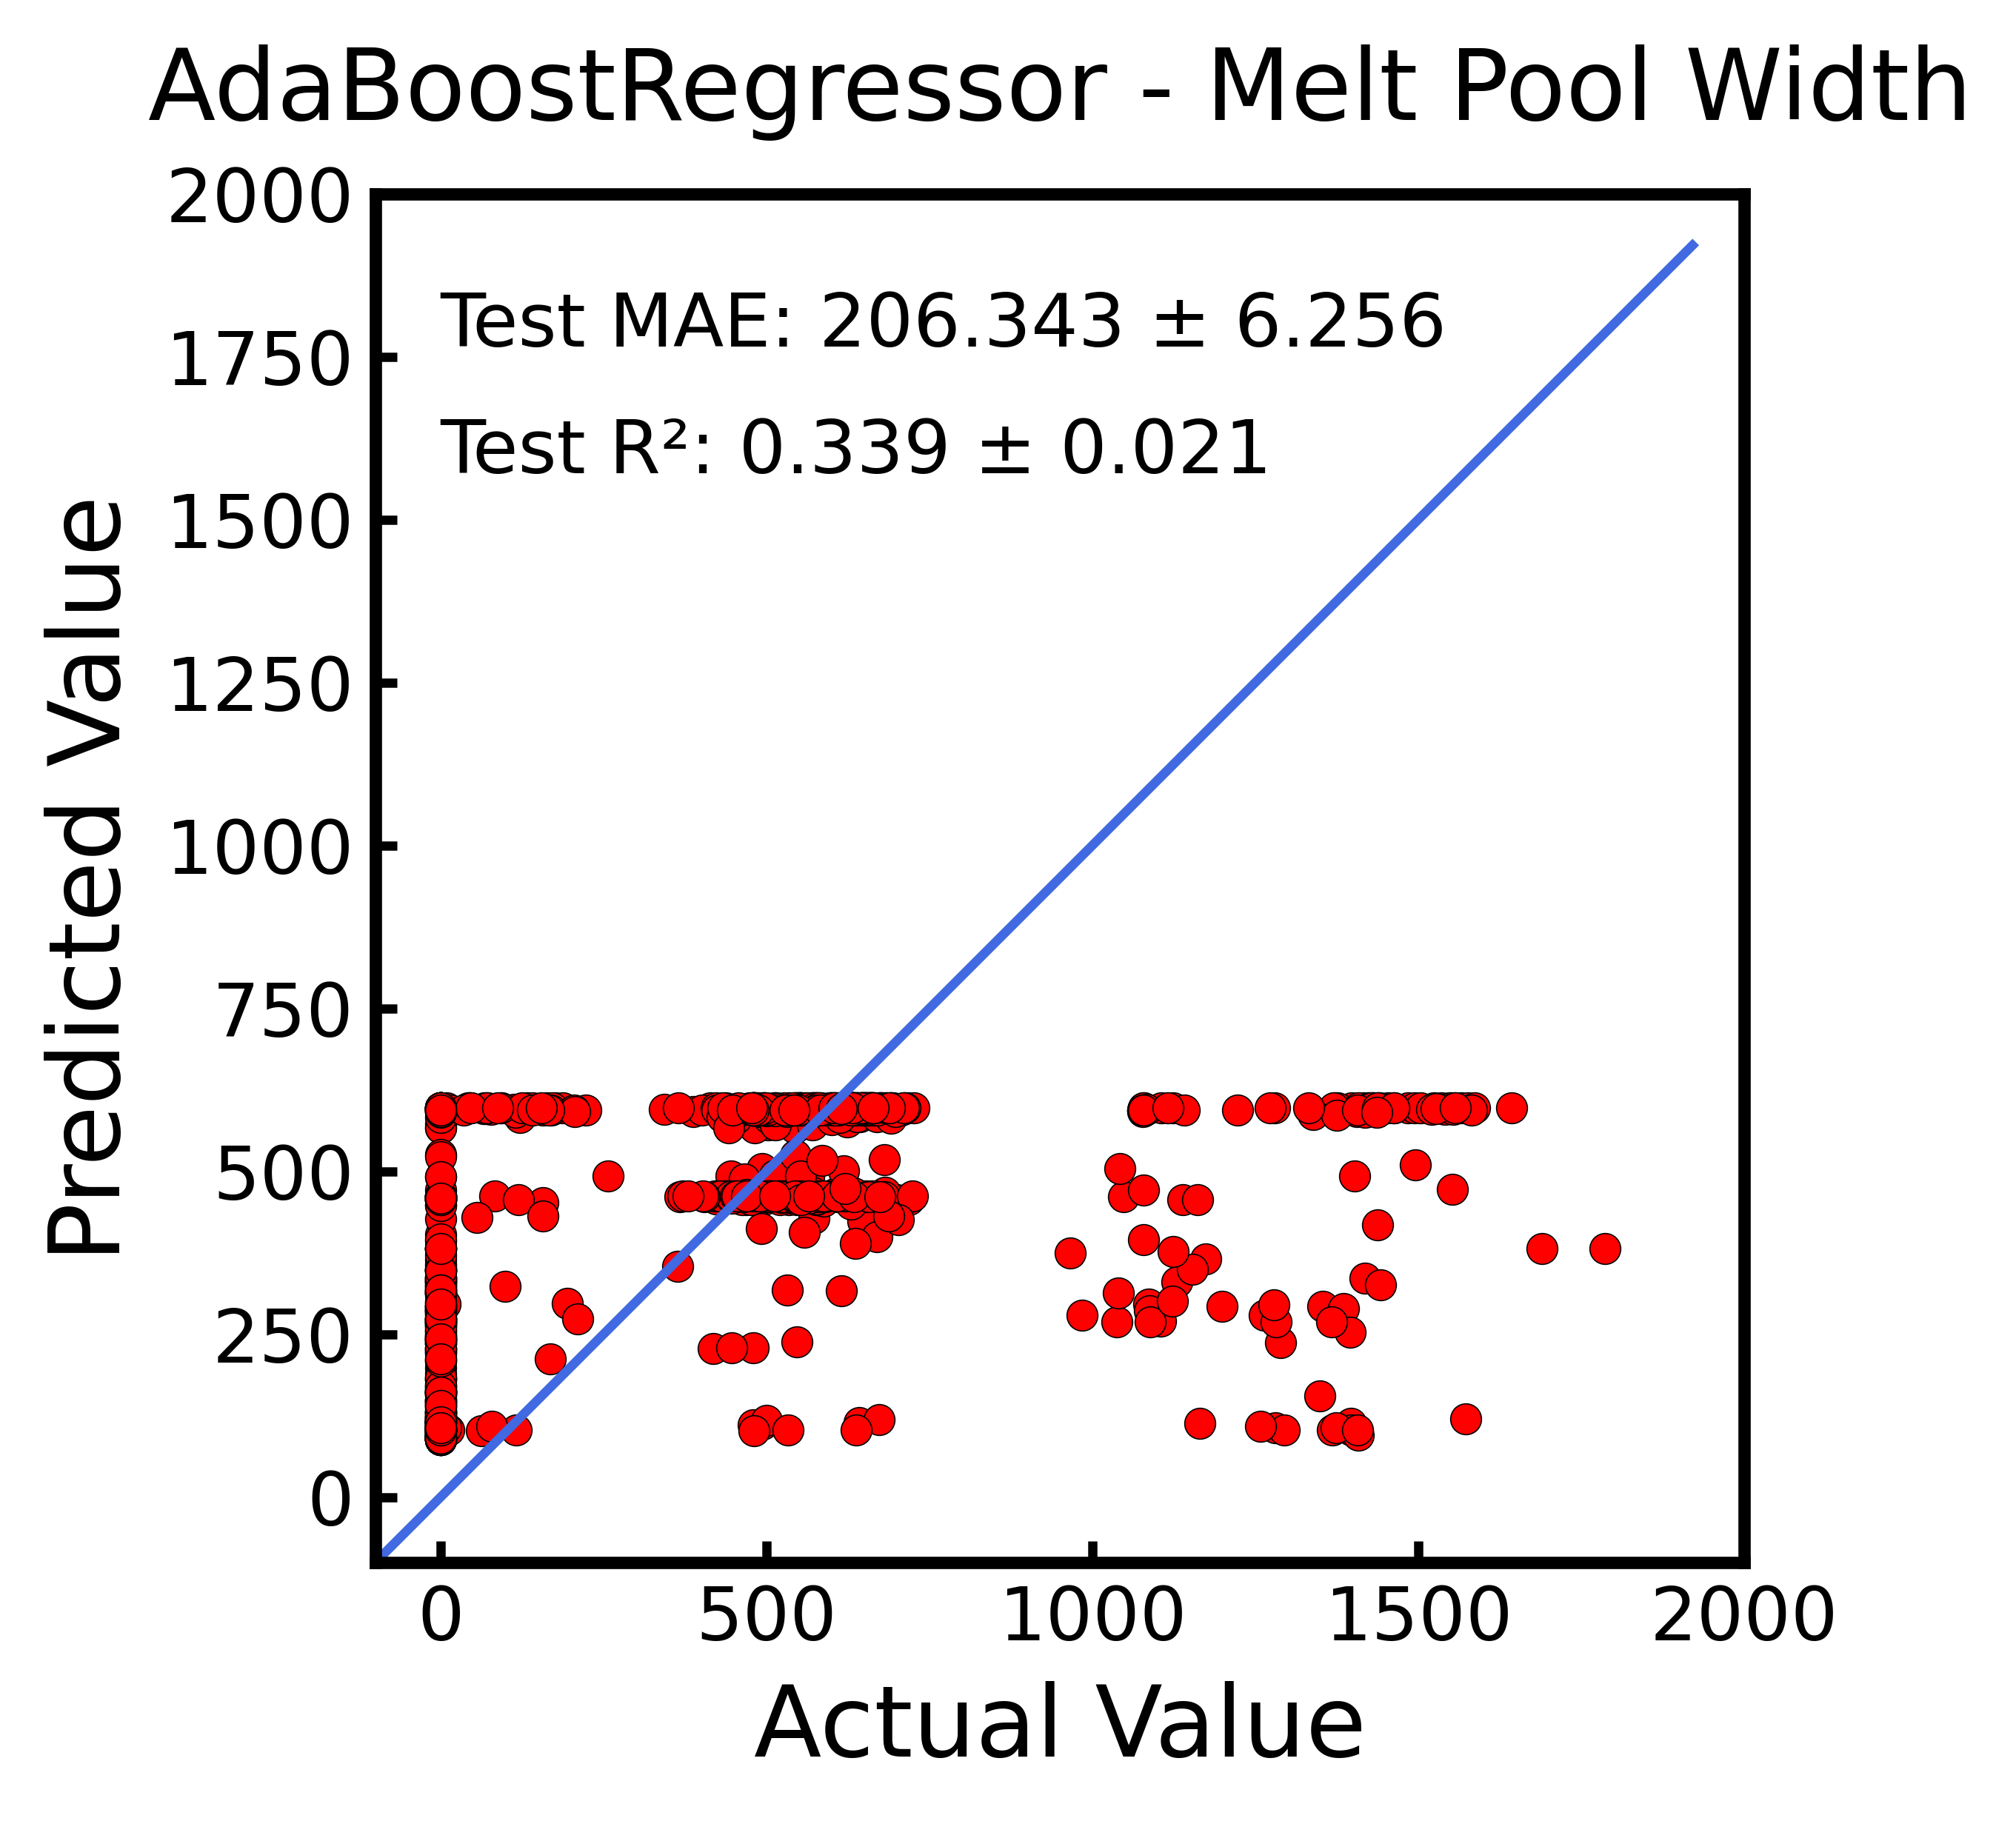

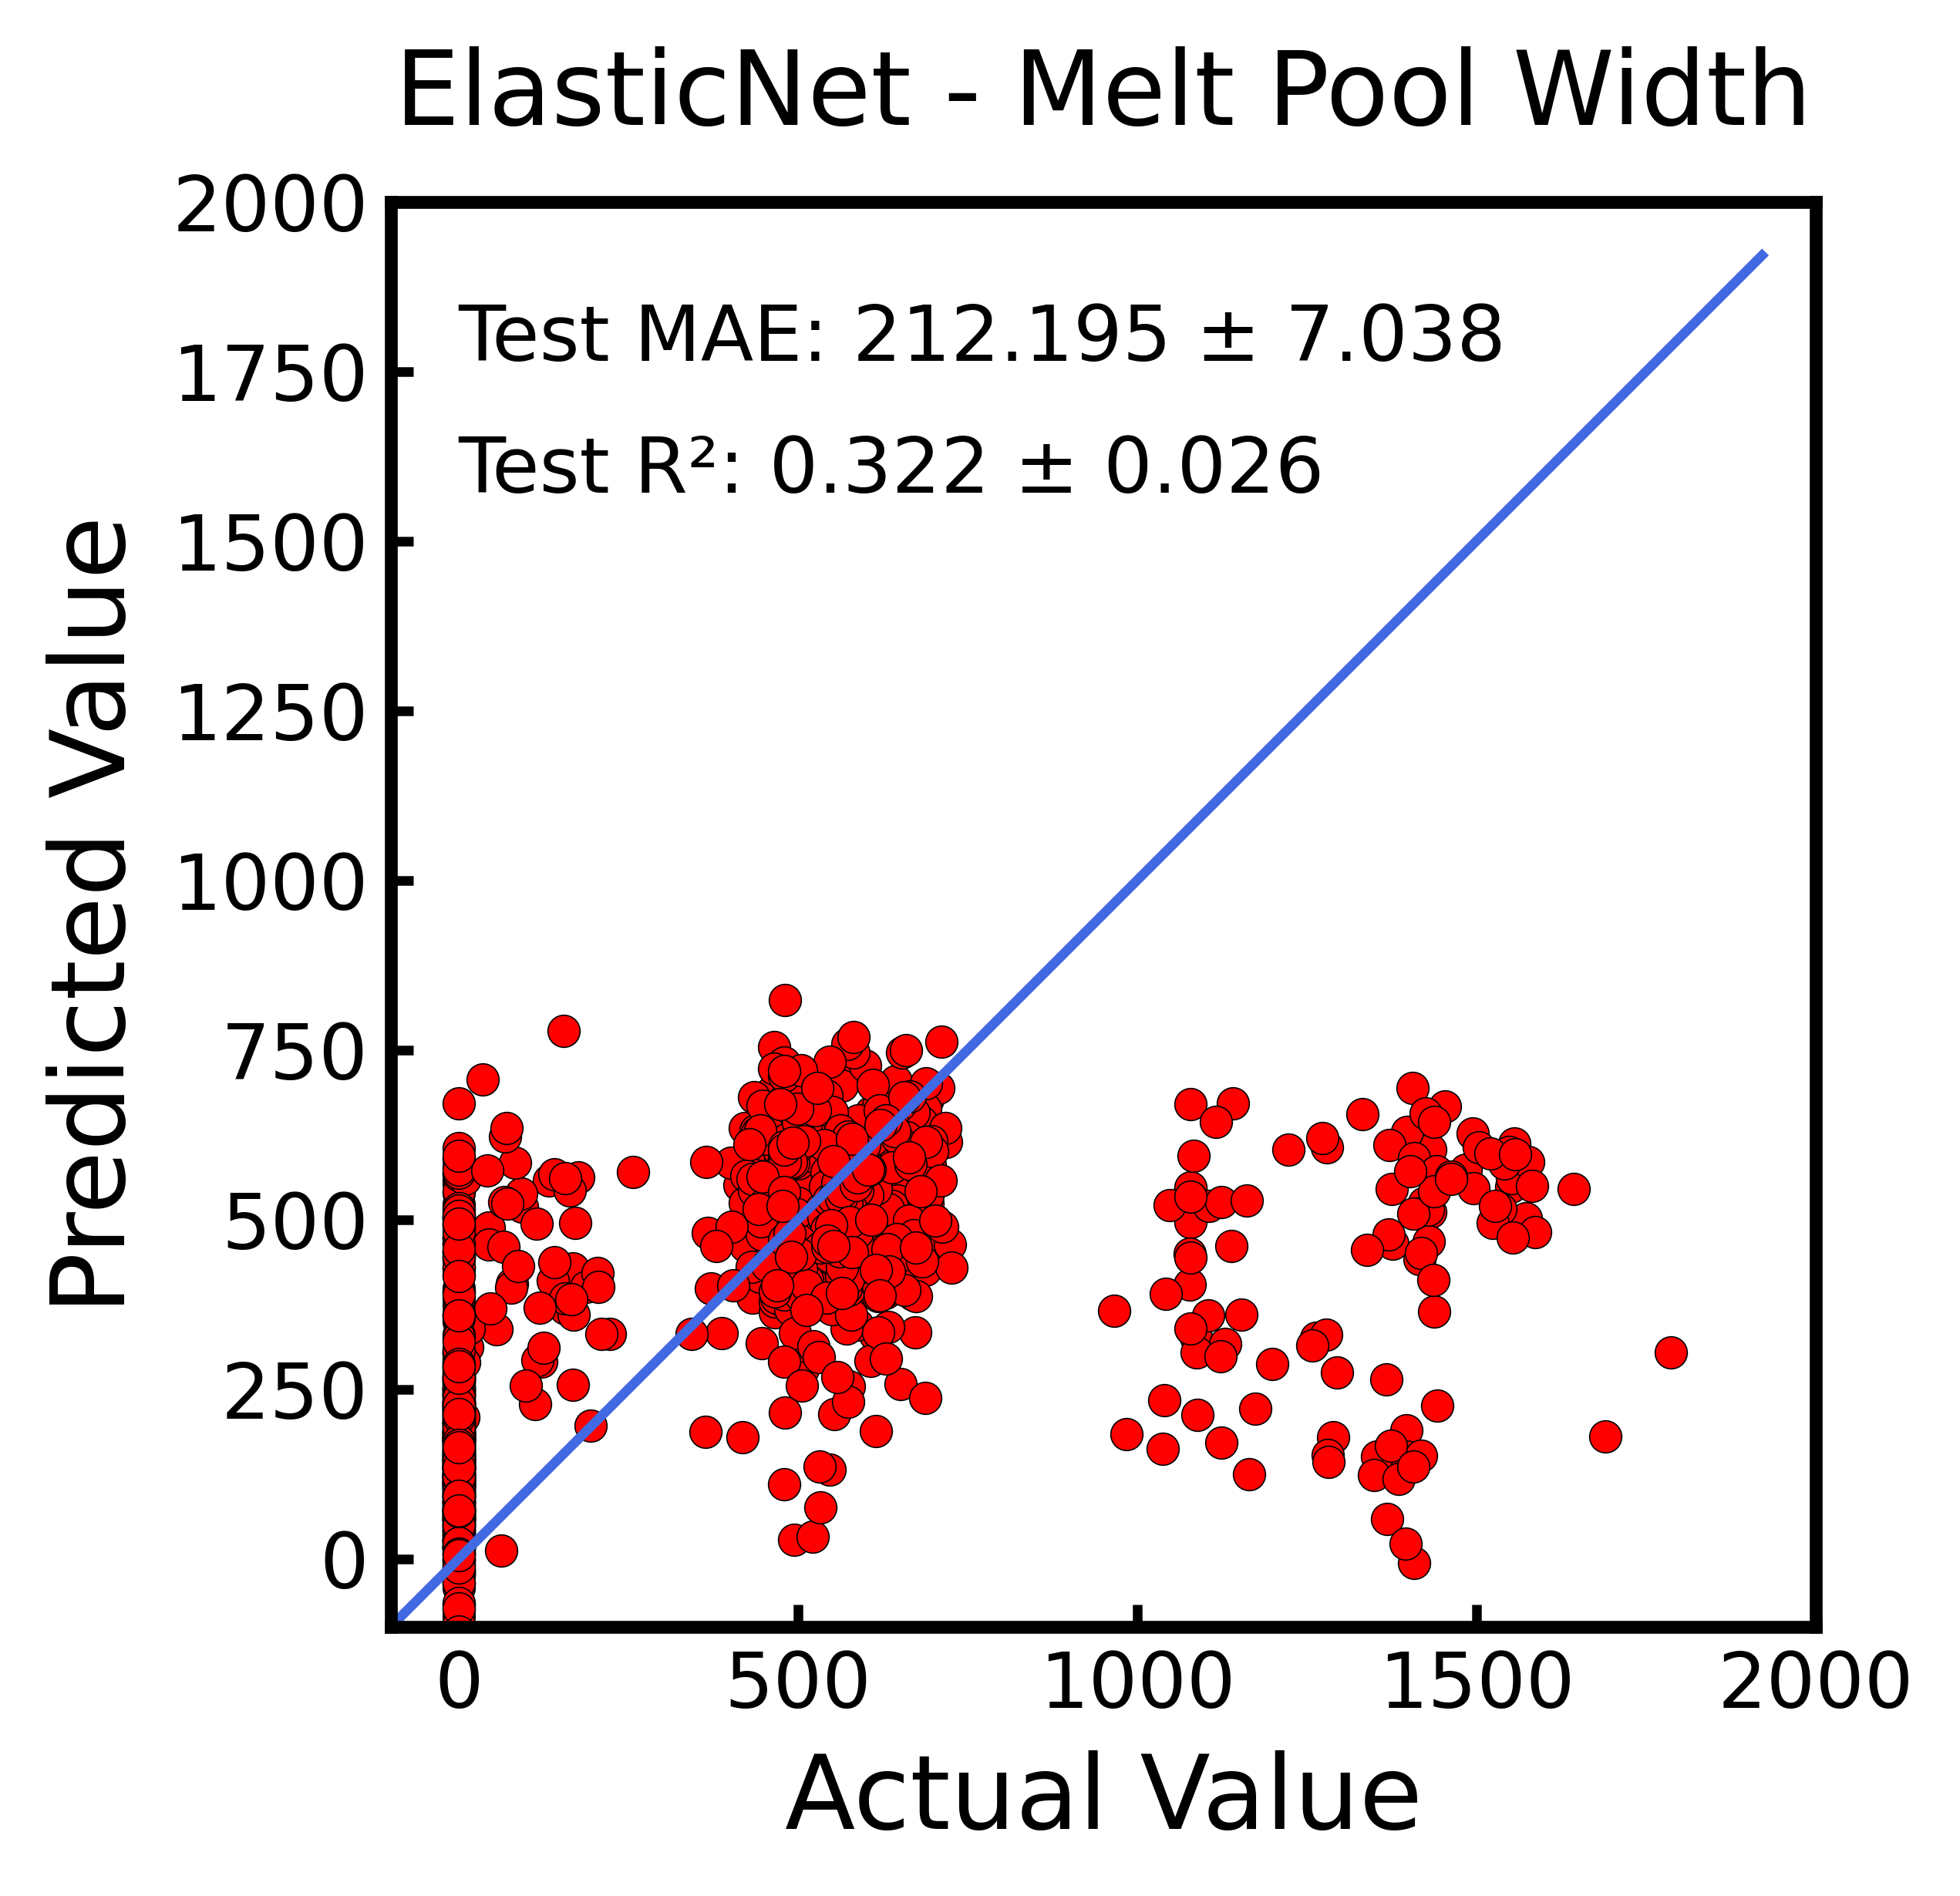

In [71]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in trained_models.items():
    title = "Melt Pool Width"

    maes, mses, r2s = [], [], []

    for train_index, test_index in kf.split(X_test_transformed):
        X_train, X_test = X_test_transformed[train_index], X_test_transformed[test_index]
        Y_train, Y_test = Y_ellipse_width_test[train_index], Y_ellipse_width_test[test_index]

        # Test the model
        y_pred = model.predict(X_test)

        # Calculate metrics
        maes.append(metrics.mean_absolute_error(Y_test, y_pred))
        mses.append(metrics.mean_squared_error(Y_test, y_pred))
        r2s.append(metrics.r2_score(Y_test, y_pred))

    # Calculate mean and std of metrics
    mae_mean, mae_std = np.mean(maes), np.std(maes)
    mse_mean, mse_std = np.mean(mses), np.std(mses)
    r2_mean, r2_std = np.mean(r2s), np.std(r2s)

    # Plotting the last fold for visualization
    plt.figure(figsize=(4, 4), dpi=600)
    ax = plt.gca()
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

    plt.tick_params(direction='in', width=1.5)
    plt.plot(Y_test, y_pred, '.', color='red', ms=10, mec='k', mew=0.2)
    plt.xlim([-500, 2000])  # Adjust these limits based on your data range
    plt.ylim([-500, 2000])  # Adjust these limits based on your data range
    plt.plot(np.arange(-4*np.std(Y_train)+np.mean(Y_train), 4*np.std(Y_train)+np.mean(Y_train)), 
             np.arange(-4*np.std(Y_train)+np.mean(Y_train), 4*np.std(Y_train)+np.mean(Y_train)), 'royalblue')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(f"{model_name} - {title}", fontsize=16, pad=12)
    plt.xlabel("Actual Value", fontsize=16)
    plt.ylabel("Predicted Value", fontsize=16)
    plt.text(-1, 3.3*np.std(Y_train)+np.mean(Y_train), f'Test R²: {r2_mean:.3f} ± {r2_std:.3f}', fontsize=12)
    plt.text(-1, 3.6*np.std(Y_train)+np.mean(Y_train), f'Test MAE: {mae_mean:.3f} ± {mae_std:.3f}', fontsize=12)
    # plt.text(-1, 1.6*np.std(Y_train)+np.mean(Y_train), f'Test MSE: {mse_mean:.3f} ± {mse_std:.3f}', fontsize=12)
    plt.gca().set_aspect('equal')

    save_fig(f'{model_name}_without_spatial')